In [1]:
import pandas as pd
import numpy as np
import os
from pprint import pprint

from scipy.stats import rankdata, mannwhitneyu, wilcoxon, gmean
from collections import Counter
from analysis_utils import (
    get_comorb_drugs_data_for_one_comorb_known_drugs,
    get_highest_and_lowest_drug_pairs, 
)
from madrigal.utils import BASE_DIR

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

DDI_PATH = BASE_DIR + 'processed_data/polypharmacy_new/DrugBank/'
VIEWS_PATH = BASE_DIR + 'processed_data/views_features_new/'

['str', 'kg', 'cv']


# Utils

In [ ]:
raw_drugbank_df = pd.read_pickle('../raw_drugbank_df.pkl')
print(raw_drugbank_df.columns)

drug_metadata = pd.read_pickle(os.path.join(VIEWS_PATH, "combined_metadata_ddi.pkl"))
drug_metadata["view_str"] = 1
drug_metadata_nash = pd.read_pickle(os.path.join(VIEWS_PATH, "combined_metadata_nash.pkl"))
drug_metadata_nash["view_str"] = 1

drug_metadata = drug_metadata.merge(
    raw_drugbank_df[["drugbank_id", "drug_type", "description", "indication", "moa", "toxicity", "atc_codes", "targets"]].rename(columns={"indication":"indication_drugbank"}), 
    left_on='node_id', right_on='drugbank_id', how='left'
).drop(columns=[
    col for col in drug_metadata.columns 
    if col.endswith("_sig_id") or col.endswith("_pert_dose") or col.endswith("_sig_id") or (col in {"inchi_key", "drugbank_id", "cv_dose"})
])

drug_metadata_nash = drug_metadata_nash.merge(
    raw_drugbank_df[["drugbank_id", "drug_type", "description", "indication", "moa", "toxicity", "atc_codes", "targets"]].rename(columns={"indication":"indication_drugbank"}), 
    left_on='node_id', right_on='drugbank_id', how='left'
).drop(columns=[
    col for col in drug_metadata_nash.columns 
    if col.endswith("_sig_id") or col.endswith("_pert_dose") or col.endswith("_sig_id") or (col in {"inchi_key", "drugbank_id", "cv_dose"})
])

# use primekg to get real indications of disease
primekg = pd.read_csv(BASE_DIR + 'raw_data/PrimeKG/kg.csv')
assert primekg[["x_index", "y_index"]].drop_duplicates().shape[0] == pd.concat([
    primekg[["x_index", "y_index"]],
    primekg[["x_index", "y_index"]].rename(columns={"x_index":"y_index", "y_index":"x_index"}),
], axis=1).drop_duplicates().shape[0]  # ensure it's bidirectional

# confirm that "best" drug pairs don't have adverse ddi effects with another dataset
db_polypharmacy = pd.read_csv(DDI_PATH + 'drugbank_ddi_directed_final.tsv', index_col=None)[["label_indexed", "drug_index_1", "drug_index_2"]]
db_polypharmacy = pd.concat([
    db_polypharmacy,
    db_polypharmacy.rename(columns={"drug_index_1":"drug_index_2", "drug_index_2":"drug_index_1"})
], axis=0).drop_duplicates()

# FDA approved drugs from Drugbank site
approved_drugs = pd.read_csv('../approved_drug_link.csv')
organs_csv = pd.read_csv('../drugbank_ddi_organs.csv', sep='\t')
organ_class_mapping = organs_csv.set_index("ddi_class").to_dict()["organ"]  # ddi_class : organ

organ_lst = []
for organs in organ_class_mapping.values():
    organ_lst.extend(organs.split(", "))
organ_counts = Counter(organ_lst)

In [5]:
ddi_classes = pd.read_pickle(DDI_PATH + "drugbank_ddi_directed_final_label_map.pkl")
all_labels = list(range(len(ddi_classes)))
train_labels = pd.read_csv(DDI_PATH + "split_by_pairs/train_df.csv")["label_indexed"].unique()
assert train_labels.shape[0] == len(ddi_classes)

to_delete = [
    10, 
    38, 
    65, 
    72,
    83,
    99, 
    147
]
to_delete_classes = [
    "adverse effects, decrease", 
    "cardiotoxicity, decrease",
    "hypertension, decrease",
    "hypoglycemia, decrease",
    "hypotension, decrease",
    "nephrotoxicity, decrease",
    "therapeutic efficacy, increase",
]
valid_ddi_class_indices = np.array([elem for elem in all_labels if elem not in to_delete])
csv_headers = [ddi_classes[i] for i in valid_ddi_class_indices]

In [6]:
data_source = "DrugBank"
split_method = "split_by_pairs"
dtype = np.dtype("float32")  # "float32"
# NOTE: The local normalized rank is sorted in an ascending manner, i.e. the lower the normalized rank, the less likely the DDI event is true (the safer the drug pair is in terms of the DDI class)
normalized_rank_drugbank = np.load(BASE_DIR + f"model_output/{data_source}/{split_method}/full_full_all_ddi_DrugBank_nash_drugs_normalized_ranks_700_5_runs_gmean_renormalized.npy", mmap_mode="r")

In [7]:
organs_of_interest = [
    "blood", 
    "heart", 
    "kidney", 
    "gastrointestinal", 
    "liver", 
    "endocrine", 
]

custom_palette = {
    "others/general": "grey", 
    "blood": "orange",  # lightpink
    "heart": "red",  # marron
    "kidney": "purple",  # darkmagenta
    "gastrointestinal": "green",  # mediumseagreen
    "liver": "blue",  # cornflowerblue, steelblue
    "endocrine": "darkkhaki",
}

drug_ind_to_name = drug_metadata["node_name"].dropna().to_dict()
drug_name_to_ind = {name.lower():ind for ind, name in drug_ind_to_name.items()}
drug_id_to_name = drug_metadata[["node_id", "node_name"]].dropna().set_index("node_id").to_dict()["node_name"]
drug_name_to_id = {name.lower():drug_id for drug_id, name in drug_id_to_name.items()}

drug_ind_to_name_nash = drug_metadata_nash["node_name"].dropna().to_dict()
drug_name_to_ind_nash = {name.lower():ind for ind, name in drug_ind_to_name_nash.items()}
drug_id_to_name_nash = drug_metadata_nash[["node_id", "node_name"]].dropna().set_index("node_id").to_dict()["node_name"]
drug_name_to_id_nash = {name.lower():drug_id for drug_id, name in drug_id_to_name_nash.items()}

primekg_indication = primekg[primekg["relation"] == "indication"]

In [8]:
t2d_drugs_to_remove = ["carbutamide", "buformin", "troglitazone"]

d1 = 5148  # T2D
d1_name = "type 2 diabetes mellitus"

d1_drugs = primekg_indication[
    (
        (primekg_indication['x_name'] == 'type 2 diabetes mellitus') | \
        (primekg_indication['x_name'] == 'Type II diabetes mellitus')
    ) & \
    (primekg_indication['y_type'] == 'drug') & (primekg_indication['relation'] == 'indication')
]['y_id'].values
d1_drugs = list((set(d1_drugs) & set(drug_metadata["node_id"].dropna().values)) - set([drug_name_to_id[drug] for drug in t2d_drugs_to_remove]))
d1_drugs += ["DB00412"]  # ADD Rosiglitazone
assert len(d1_drugs) > 0
print(len(d1_drugs))

41


Refine MoAs from:
- [Diabetes.org](https://diabetes.org/health-wellness/medication/oral-other-injectable-diabetes-medications)
- [UCSF](https://dtc.ucsf.edu/types-of-diabetes/type2/treatment-of-type-2-diabetes/medications-and-therapies/type-2-non-insulin-therapies/table-of-medications/)
- [Cleveland Clinic](https://my.clevelandclinic.org/health/articles/12070-oral-diabetes-medications)
- [Mayo Clinic](https://www.mayoclinic.org/diseases-conditions/type-2-diabetes/in-depth/diabetes-treatment/art-20051004)

In [ ]:
t2d_drug_moas = {
    "metformin": "insulin sensitizer (biguanides)",
    "sitagliptin": "DPP4i",
    "linagliptin": "DPP4i",  
    "canagliflozin": "SGLT2i",
    "rosiglitazone": "insulin sensitizer (thiazolidinediones)",
    "glimepiride": "sulfonylureas", 
    "acarbose": "glucosidase inhibitor",
    "miglitol": "glucosidase inhibitor",
    "chlorpropamide": "sulfonylureas", 
    "nateglinide": "meglitinides (glinides)",
    "tolazamide": "sulfonylureas",
    "repaglinide": "meglitinides (glinides)",
    "glyburide": "sulfonylureas",
    "glipizide": "sulfonylureas",
    "gliclazide": "sulfonylureas",  # not in US
    "tolbutamide": "sulfonylureas",
    "pioglitazone": "insulin sensitizer (thiazolidinediones)",
    "gliquidone": "sulfonylureas", 
    "vildagliptin": "DPP4i",  # not in US
    "alogliptin": "DPP4i",
    "dapagliflozin": "SGLT2i",
    "saxagliptin": "DPP4i",
    "empagliflozin": "SGLT2i",
    "acetohexamide": "sulfonylureas",
    "mitiglinide": "meglitinides (glinides)",  # not in US
    "glisoxepide": "sulfonylureas",  # not in US
    "voglibose": "glucosidase inhibitor",  # not in US
    "glibornuride": "sulfonylureas",  # not in US
    "lobeglitazone": "insulin sensitizer (thiazolidinediones)",  # not in US
    "lixisenatide": "GLP1 analogs",
    "ipragliflozin": "SGLT2i",  # not in US
    "tofogliflozin": "SGLT2i",
    "ertugliflozin": "SGLT2i",
    "teneligliptin": "DPP4i",  # not in US
    "omarigliptin": "DPP4i",  # not in US
    "gemigliptin": "DPP4i",  # not in US
    "anagliptin": "DPP4i",  # not in US
    "evogliptin": "DPP4i",  # not in US
    "semaglutide": "GLP1 analogs",
    "luseogliflozin": "SGLT2i",
    "trelagliptin": "DPP4i",  # not in US
}

Counter(list(t2d_drug_moas.values()))

Counter({'insulin sensitizer (biguanides)': 1,
         'DPP4i': 11,
         'SGLT2i': 7,
         'insulin sensitizer (thiazolidinediones)': 3,
         'sulfonylureas': 11,
         'glucosidase inhibitor': 3,
         'meglitinides (glinides)': 3,
         'GLP1 analogs': 2})

# T2D

In [10]:
d1_drug_names = [drug_id_to_name[drug_id].lower() for drug_id in d1_drugs]

_, both_t2d_df_filtered = get_comorb_drugs_data_for_one_comorb_known_drugs(
    d1_drugs, d1_name, d1_drug_names, "T2D",
    drug_metadata, normalized_rank_drugbank, ddi_classes, to_delete_classes, drug_ind_to_name,
)
both_t2d_df_filtered = both_t2d_df_filtered.drop_duplicates()
assert both_t2d_df_filtered.shape[0] == len(d1_drugs) * (len(d1_drugs) - 1) / 2

overlap
overlap
overlap
overlap
overlap
overlap
overlap
overlap
overlap
overlap
overlap
overlap
overlap
overlap
overlap
overlap
overlap
overlap
overlap
overlap
overlap
overlap
overlap
overlap
overlap
overlap
overlap
overlap
overlap
overlap
overlap
overlap
overlap
overlap
overlap
overlap
overlap
overlap
overlap
overlap
overlap


In [11]:
both_t2d_df_filtered_rational = both_t2d_df_filtered[both_t2d_df_filtered.index.map(
    lambda x: True if t2d_drug_moas[x.split("; ")[-1]] != t2d_drug_moas[x.split("; ")[-2]] else False)]
both_t2d_df_filtered_rational = pd.melt(both_t2d_df_filtered_rational.reset_index(), id_vars=both_t2d_df_filtered_rational.index.name, var_name="ddi_class")
both_t2d_df_filtered_rational[["temp_1", "temp_2", "drug_1", "drug_2"]] = both_t2d_df_filtered_rational["(Disease 1; Disease 2; Drug 1; Drug 2)"].str.split("; ", expand=True)
both_t2d_df_filtered_rational = both_t2d_df_filtered_rational.drop(columns=["temp_1", "temp_2", "(Disease 1; Disease 2; Drug 1; Drug 2)"])
both_t2d_df_filtered_rational = both_t2d_df_filtered_rational.merge(organs_csv, on="ddi_class", how="left")
both_t2d_df_filtered_rational["organ"] = both_t2d_df_filtered_rational["organ"].str.split(", ")
both_t2d_df_filtered_rational_organ = both_t2d_df_filtered_rational.explode(column="organ").query("organ in @organs_of_interest")

### Rosiglitazone vs. pioglitazone wrt myocardial infarction

In [12]:
temp = pd.concat([
    both_t2d_df_filtered_rational,
    both_t2d_df_filtered_rational.rename(columns={"drug_1":"drug_2", "drug_2":"drug_1"})
])
temp = pd.pivot_table(temp, values="value", index=["drug_1", "drug_2"], columns="ddi_class").reset_index()

In [13]:
plot_data = (
    temp[temp["drug_1"].isin({"rosiglitazone", "pioglitazone"})].
    groupby("drug_1").agg(list).drop(columns=["drug_2"])[[
        'QTc prolongation, hypotension, increase',
        'QTc prolongation, increase',
        'QTc prolongation, torsade de pointes, cardiotoxicity, increase',
        'atrioventricular blocking (AV block), increase',
        'cardiac arrhythmia, CNS stimulation, increase',
        'cardiac arrhythmia, cardiotoxicity, increase',
        'cardiac arrhythmia, increase',
        'cardiotoxicity, increase',
        'congestive heart failure, hypotension, increase',
        'ventricular arrhythmias, cardiac arrhythmia, increase',
        
        'hypertension, hyponatremia, water intoxication, increase',
        'hypertension, increase',
        'hypertension, tardive dyskinesia, increase',
        'hypertension, vasoconstricting, increase',
        'hypotension, CNS depression, increase',
        'hypotension, Electrolyte Disturbance, increase',
        'hypotension, hyperkalemia, nephrotoxicity, increase',
        'hypotension, increase',
        'hypotension, nitritoid reactions, facial flushing, nausea, vomiting, increase',
        'hypotension, orthostatic hypotension, increase',
        'hypotension, sedation, death, somnolence, respiratory depression, increase',
        'hypotension, syncope, increase',
        'orthostatic hypotension, dizziness, increase',
        'orthostatic hypotension, hypotension, antihypertension, increase',
        'orthostatic hypotension, increase',
        'orthostatic hypotension, syncope, increase',
    ]].
    applymap(np.mean)
).T

plot_data = pd.melt(plot_data.reset_index(), id_vars="ddi_class", value_vars=["pioglitazone", "rosiglitazone"], value_name="score", var_name="drug")

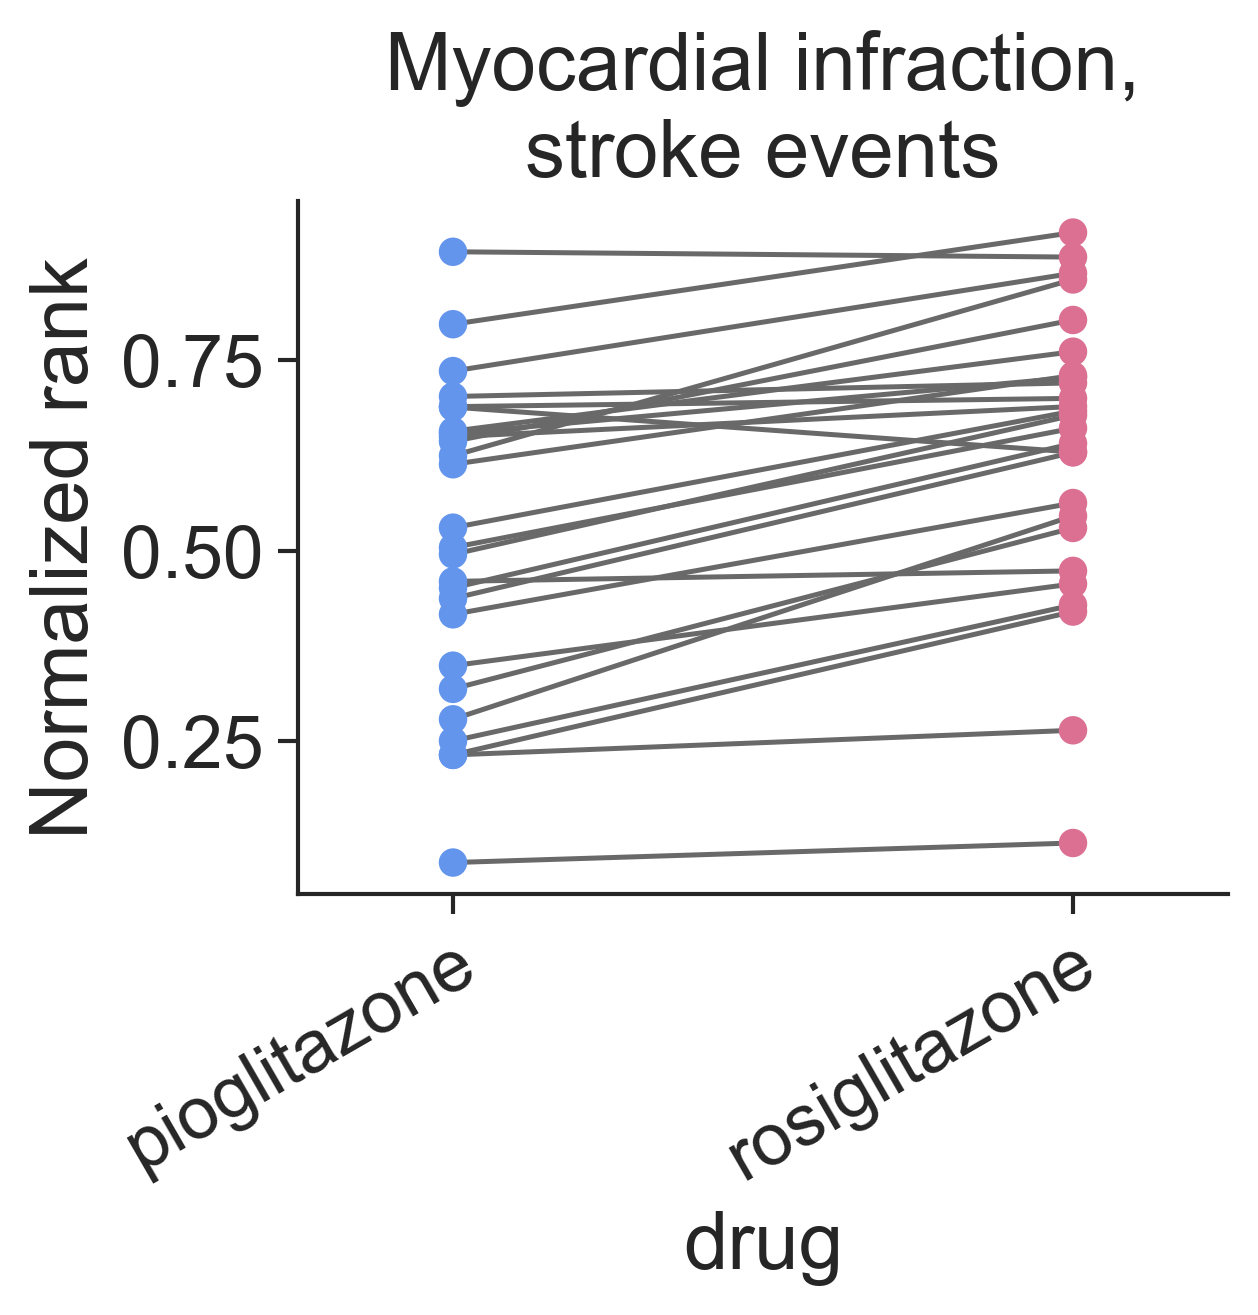

WilcoxonResult(statistic=342.0, pvalue=4.917383193969727e-07)


In [ ]:
good_col = "cornflowerblue"
bad_col = "palevioletred"

from matplotlib import font_manager as fm
arial_path = "../arial.ttf"
fm.fontManager.addfont(arial_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

fig = plt.figure(figsize=(4, 3), dpi=300)
sns.set(context="paper", style="ticks", font_scale=2)

g1 = sns.lineplot(plot_data, x="drug", y="score", hue="ddi_class", dashes=False, zorder=1, legend=False, palette=["dimgray"]*plot_data["ddi_class"].nunique())
g2 = sns.scatterplot(plot_data, x="drug", y="score", hue="drug", color="dimgray", 
                     edgecolor=None, palette={"rosiglitazone":bad_col, "pioglitazone":good_col}, zorder=2, s=40)

g1.legend_.remove()
plt.xlim(-0.25, 1.25)
plt.ylabel("Normalized rank")
plt.title("Myocardial infraction,\nstroke events")
plt.xticks(rotation=30, ha="right", rotation_mode="anchor")
sns.despine()

plt.savefig("./fig6_t2d+t2d_pioglitazone_rosiglitazone_mi.svg", format="svg", dpi=300)
plt.show()

print(
    wilcoxon(plot_data.query("drug == 'rosiglitazone'").sort_values("ddi_class")["score"].values, 
             plot_data.query("drug == 'pioglitazone'").sort_values("ddi_class")["score"].values,
             alternative="greater")
)

# T2D + HF

Primarily:
- heart failure
- congestive heart failure

Also: [AHA website](https://www.heart.org/en/health-topics/heart-failure/treatment-options-for-heart-failure/medications-used-to-treat-heart-failure)


In [35]:
aha_heart_failure_drugs = {
    "ACEi": ["Captopril", "Enalapril", "Fosinopril", "Lisinopril", "Perindopril", "Quinapril", 
             "Ramipril", "Trandolapril", "Benazepril", "Moexipril"],
    "ARB/ARNi": ["Candesartan", "Losartan", "Valsartan", "Sacubitril"],  # angiotensin ii receptor blockers; angiotensin receptor-neprilysin inhibitors
    "Aldosterone antagonist": ["Spironolactone", "Eplerenone"],  # i.e. mieralocorticoid receptor antagonist (MRAs)
    "If channel blocker": ["Ivabradine"],
    "Beta blocker": ["Acebutolol", "Atenolol", "Betaxolol", "Carvedilol", "Labetalol", 
                     "Metoprolol", "Nadolol", "Nebivolol", "Pindolol", "Propranolol"],
    "SGLT2i": ["Empagliflozin", "Dapagliflozin"],
    "Diuretics": ["Furosemide", "Bumetanide", "Torasemide", "Chlorothiazide", "Amiloride", 
                  "Hydrochlorothiazide", "Indapamide", "Metolazone", "Triamterene"] 
}
aha_heart_failure_drug_moas = {}
for moa, drugs in aha_heart_failure_drugs.items():
    for drug in drugs:
        aha_heart_failure_drug_moas[drug.lower()] = moa

In [36]:
aha_heart_failure_drugs_mapped = []
for moa, lst in aha_heart_failure_drugs.items():
    for drug in lst:
        mapped_name = drug_metadata[drug_metadata["node_name"].str.lower().str.replace(" ", "") == drug.lower().replace(" ", "")]["node_name"].values
        if mapped_name.shape[0] > 0:
            aha_heart_failure_drugs_mapped.append(mapped_name[0].lower())
        else:
            print(drug, "-- NO MATCH")
print(len(aha_heart_failure_drugs_mapped))

38


In [37]:
_, t2d_hf_df_filtered = get_comorb_drugs_data_for_one_comorb_known_drugs(
    d1_drugs, d1_name, aha_heart_failure_drugs_mapped, "Heart failure",
    drug_metadata, normalized_rank_drugbank, ddi_classes, to_delete_classes, drug_ind_to_name,
)

overlap
overlap


In [38]:
t2d_hf_df_filtered_rational = t2d_hf_df_filtered[t2d_hf_df_filtered.index.map(
    lambda x: True if t2d_drug_moas[x.split("; ")[-2]] != aha_heart_failure_drug_moas[x.split("; ")[-1]] else False)]
t2d_hf_df_filtered_rational = pd.melt(t2d_hf_df_filtered_rational.reset_index(), 
                                      id_vars=t2d_hf_df_filtered_rational.index.name, var_name="ddi_class")
t2d_hf_df_filtered_rational[["temp_1", "temp_2", "drug_1", "drug_2"]] = t2d_hf_df_filtered_rational["(Disease 1; Disease 2; Drug 1; Drug 2)"].str.split("; ", expand=True)
t2d_hf_df_filtered_rational = t2d_hf_df_filtered_rational.drop(columns=["temp_1", "temp_2", "(Disease 1; Disease 2; Drug 1; Drug 2)"])
t2d_hf_df_filtered_rational = t2d_hf_df_filtered_rational.merge(organs_csv, on="ddi_class", how="left")
t2d_hf_df_filtered_rational["organ"] = t2d_hf_df_filtered_rational["organ"].str.split(", ")
t2d_hf_df_filtered_rational_organ = t2d_hf_df_filtered_rational.explode(column="organ").query("organ in @organs_of_interest")

## Outcome-specific checks

In [39]:
t2d_hf_df_filtered_rational_wide = pd.pivot_table(t2d_hf_df_filtered_rational, values="value", index=["drug_1", "drug_2"], columns="ddi_class").reset_index()

### Hyperkalemia

In [40]:
plot_data = (
    t2d_hf_df_filtered_rational_wide.rename(columns={"drug_1":"drug_2", "drug_2":"drug_1"}).
    groupby("drug_1").agg(list).drop(columns=["drug_2"])[[
        'hyperkalemia, increase',
        'hypotension, hyperkalemia, nephrotoxicity, increase',
        'renal failure, hyperkalemia, hypertension, increase',
        'renal failure, hypotension, hyperkalemia, increase',
    ]].
    # applymap(np.median)
    explode(column=[
        'hyperkalemia, increase',
        'hypotension, hyperkalemia, nephrotoxicity, increase',
        'renal failure, hyperkalemia, hypertension, increase',
        'renal failure, hypotension, hyperkalemia, increase',
    ])
).reset_index().rename_axis(columns=None)
plot_data["HF_drug_category"] = plot_data["drug_1"].apply(lambda x: aha_heart_failure_drug_moas[x])
display(plot_data)

,drug_1,"hyperkalemia, increase","hypotension, hyperkalemia, nephrotoxicity, increase","renal failure, hyperkalemia, hypertension, increase","renal failure, hypotension, hyperkalemia, increase",HF_drug_category
0,acebutolol,0.813396,0.898391,0.145444,0.974506,Beta blocker
1,acebutolol,0.898818,0.608827,0.331252,0.824466,Beta blocker
2,acebutolol,0.98235,0.869175,0.715745,0.967015,Beta blocker
3,acebutolol,0.839122,0.88062,0.090065,0.96555,Beta blocker
4,acebutolol,0.998502,0.985796,0.53877,0.996728,Beta blocker
...,...,...,...,...,...,...
1539,valsartan,0.977091,0.8875,0.957609,0.9741,ARB/ARNi
1540,valsartan,0.98116,0.908536,0.967047,0.98314,ARB/ARNi
1541,valsartan,0.821923,0.931763,0.243044,0.996239,ARB/ARNi
1542,valsartan,0.842929,0.932231,0.419806,0.997515,ARB/ARNi


In [48]:
plot_data["Hyperkalemia outcomes"] = plot_data[[
    'hyperkalemia, increase',
    'hypotension, hyperkalemia, nephrotoxicity, increase',
    'renal failure, hyperkalemia, hypertension, increase',
    'renal failure, hypotension, hyperkalemia, increase',
]].apply(np.max, axis=1)
plot_data["safety_concern"] = plot_data["HF_drug_category"].apply(
    lambda x: "More" if x in {"ACEi", "ARB/ARNi", "Aldosterone antagonist"} 
    else ("Less" if x in {"SGLT2i"} else "UNK")
)
plot_data = pd.concat([
    plot_data,
    plot_data.query("drug_1 == 'candesartan'").replace("ARB/ARNi", "candesartan (control)"),
], axis=0)

Whether we can see improved Hyperkalemia when combined with:
- Lokelma (sodium zirconium cyclosilicate, SZC)
- sodium polystyrene sulfonate (SPS)
- patiromer

Compare with:
- T2D drugs
- HF drugs
- random drugs


In [49]:
k_binders = ["sodium zirconium cyclosilicate"]  # tolevamer and patiromer do not have SMILES
k_binders_ids = [drug_name_to_id[drug] for drug in k_binders]

_, k_binder_hf_df_filtered = get_comorb_drugs_data_for_one_comorb_known_drugs(
    k_binders_ids, "K+ binder", aha_heart_failure_drugs_mapped, "Heart failure",
    drug_metadata, normalized_rank_drugbank, ddi_classes, to_delete_classes, drug_ind_to_name,
)

k_binder_hf_df_filtered = pd.melt(k_binder_hf_df_filtered.reset_index(), 
                                  id_vars=k_binder_hf_df_filtered.index.name, var_name="ddi_class")
k_binder_hf_df_filtered[["temp_1", "temp_2", "drug_1", "drug_2"]] = k_binder_hf_df_filtered["(Disease 1; Disease 2; Drug 1; Drug 2)"].str.split("; ", expand=True)
k_binder_hf_df_filtered = k_binder_hf_df_filtered.drop(columns=["temp_1", "temp_2", "(Disease 1; Disease 2; Drug 1; Drug 2)"])
k_binder_hf_df_filtered = k_binder_hf_df_filtered.merge(organs_csv, on="ddi_class", how="left")
k_binder_hf_df_filtered["organ"] = k_binder_hf_df_filtered["organ"].str.split(", ")

k_binder_hf_df_filtered_wide = pd.pivot_table(k_binder_hf_df_filtered, values="value", index=["drug_1", "drug_2"], columns="ddi_class").reset_index()

In [50]:
temp = (
    k_binder_hf_df_filtered_wide.rename(columns={"drug_1":"drug_2", "drug_2":"drug_1"}).
    drop(columns=["drug_2"])[[
        "drug_1",
        'hyperkalemia, increase',
        'hypotension, hyperkalemia, nephrotoxicity, increase',
        'renal failure, hyperkalemia, hypertension, increase',
        'renal failure, hypotension, hyperkalemia, increase',
    ]].rename_axis(columns=None).reset_index(drop=True)
)
temp["HF_drug_category"] = temp["drug_1"].apply(lambda x: aha_heart_failure_drug_moas[x])

temp["Hyperkalemia outcomes"] = temp[[
    'hyperkalemia, increase',
    'hypotension, hyperkalemia, nephrotoxicity, increase',
    'renal failure, hyperkalemia, hypertension, increase',
    'renal failure, hypotension, hyperkalemia, increase',
]].apply(np.max, axis=1)
temp["safety_concern"] = temp["HF_drug_category"].apply(
    lambda x: "More" if x in {"ACEi", "ARB/ARNi", "Aldosterone antagonist"} 
    else ("Less" if x in {"SGLT2i"} else "UNK")
)

temp = pd.concat([
    temp,
    temp.query("drug_1 == 'candesartan'").replace("ARB/ARNi", "candesartan (control)"),
], axis=0)

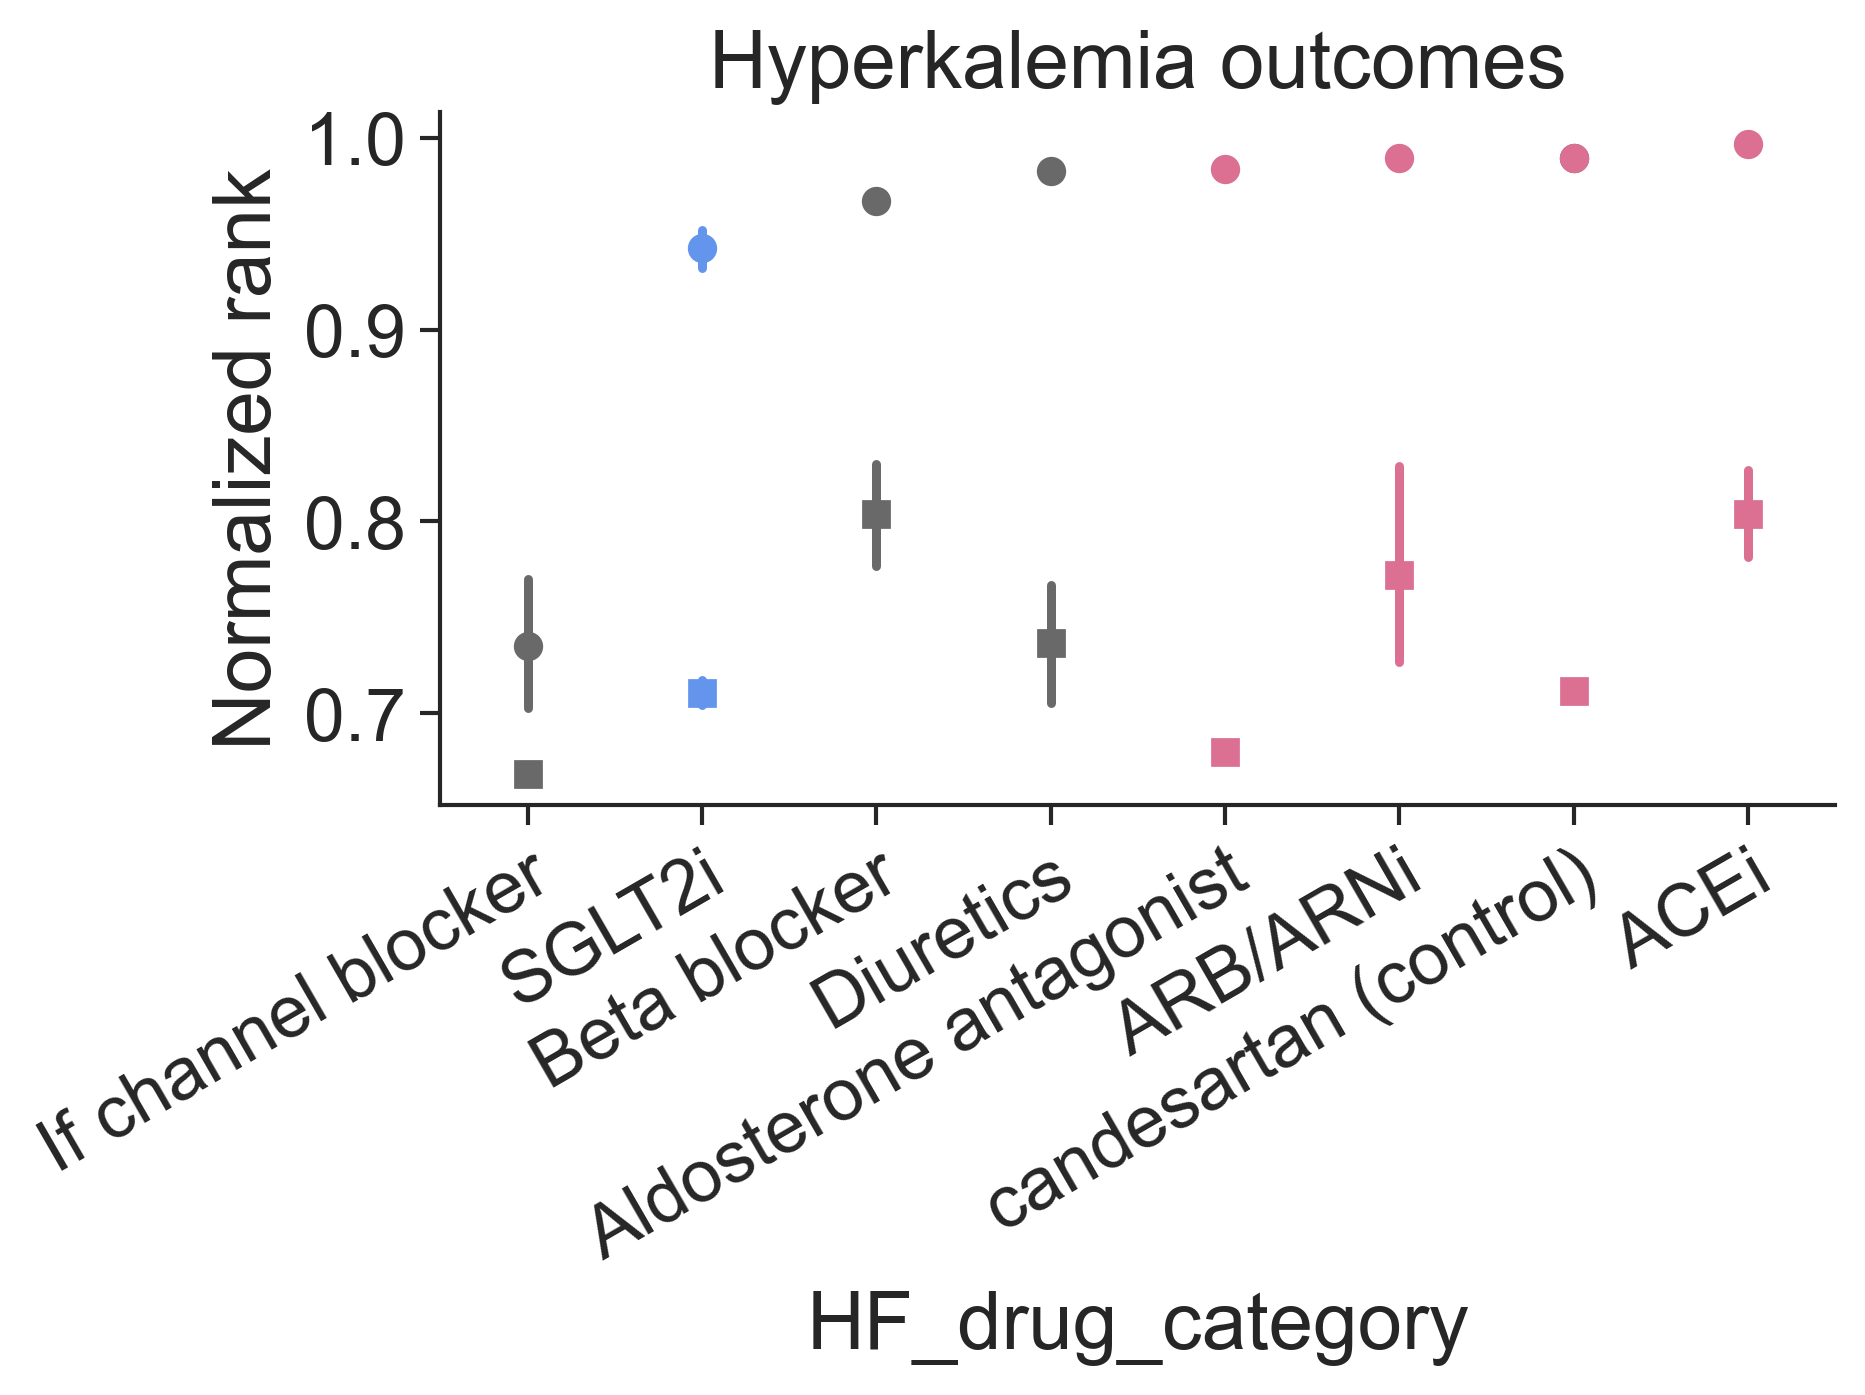

In [ ]:
outcome = "Hyperkalemia outcomes"

order = plot_data.groupby("HF_drug_category").agg(list)[outcome].apply(gmean).sort_values().index.values
good_col = "cornflowerblue"
bad_col = "palevioletred"
mid_col = "dimgray"

plt.figure(figsize=(6, 3), dpi=300)
sns.set(style="ticks", context="paper", font_scale=2)
ax1 = sns.pointplot(data=plot_data, 
                   y=outcome,
                   x="HF_drug_category", 
                   linestyle="none", order=order, hue="safety_concern",
                   palette={"More":bad_col, "Less":good_col, "UNK":mid_col}, 
                   estimator=gmean,
                  )
ax2 = sns.pointplot(data=temp, 
                     y=outcome,
                     x="HF_drug_category", 
                     hue="safety_concern",
                     linestyle="none", order=order, marker="s",
                     palette={"Less":good_col, "UNK":mid_col, "More":bad_col}, 
                     estimator=gmean, 
                    )
sns.despine()
plt.title(outcome.capitalize())
plt.ylabel("Normalized rank")
# plt.xlabel("Drug category")
ax1.get_legend().remove()
# ax2.get_legend().remove()
plt.xticks(rotation=30, ha="right", rotation_mode="anchor")
# plt.gcf().subplots_adjust(bottom=-0.05)
 
plt.savefig("./fig6_t2d+hf_hyperkalemia_score.svg", format="svg", dpi=300, pad_inches=0.2)
plt.show()

### Renal

In [53]:
# T2D + SGLT2i
sglt2i_names = ['canagliflozin', 'dapagliflozin', 'empagliflozin', 'ipragliflozin', 
                'tofogliflozin', 'ertugliflozin', 'sotagliflozin', "luseogliflozin"]
_, t2d_sglt2i_df_filtered = get_comorb_drugs_data_for_one_comorb_known_drugs(
    d1_drugs, "T2D", sglt2i_names, "SGLT2i", drug_metadata, normalized_rank_drugbank, ddi_classes, to_delete_classes, drug_ind_to_name
)

overlap
overlap
overlap
overlap
overlap
overlap
overlap


In [54]:
# T2D + diuretics
diuretics = {
    "thiazide diuretics": ["Chlorothiazide", "Chlorthalidone", "Hydrochlorothiazide", 
                           "Indapamide", "Metolazone", "Quinethazone", "Cyclopenthiazide"],
    "loop diuretics": ["Bumetanide", "Etacrynic acid", "Furosemide", "Torasemide"],
    "potassium-sparing diuretics": ["Amiloride", "Eplerenone", "Spironolactone", "Triamterene"],
}
diuretics_df = pd.DataFrame(pd.Series(diuretics)).reset_index().rename(columns={"index":"type", 0:"drug_name"}).explode("drug_name").reset_index(drop=True)
assert diuretics_df["drug_name"].apply(lambda name: name not in drug_metadata["node_name"].dropna().values).sum() == 0  # ALL IN drug_metadata
diuretics_df = diuretics_df.merge(drug_metadata[["node_name", "node_id"]].rename(columns={"node_name":"drug_name"}), on="drug_name", how="left")
diuretic_drugs = diuretics_df["node_id"].values
diuretic_names = diuretics_df["drug_name"].str.lower().values
diuretics_df

,type,drug_name,node_id
0,thiazide diuretics,Chlorothiazide,DB00880
1,thiazide diuretics,Chlorthalidone,DB00310
2,thiazide diuretics,Hydrochlorothiazide,DB00999
3,thiazide diuretics,Indapamide,DB00808
4,thiazide diuretics,Metolazone,DB00524
5,thiazide diuretics,Quinethazone,DB01325
6,thiazide diuretics,Cyclopenthiazide,DB13532
7,loop diuretics,Bumetanide,DB00887
8,loop diuretics,Etacrynic acid,DB00903
9,loop diuretics,Furosemide,DB00695


In [55]:
_, t2d_diuretic_df_filtered = get_comorb_drugs_data_for_one_comorb_known_drugs(
    d1_drugs, "T2D", diuretic_names, "diuretics", drug_metadata, normalized_rank_drugbank, ddi_classes, to_delete_classes, drug_ind_to_name
)

Process SGLT2i df and diuretics df

In [56]:
t2d_sglt2i_df_filtered_rational = t2d_sglt2i_df_filtered[t2d_sglt2i_df_filtered.index.map(
    lambda x: True if t2d_drug_moas[x.split("; ")[-2]] != "SGLT2i" else False)]
t2d_sglt2i_df_filtered_rational = pd.melt(t2d_sglt2i_df_filtered_rational.reset_index(), 
                                          id_vars=t2d_sglt2i_df_filtered_rational.index.name, var_name="ddi_class")
t2d_sglt2i_df_filtered_rational[["temp_1", "temp_2", "drug_1", "drug_2"]] = t2d_sglt2i_df_filtered_rational["(Disease 1; Disease 2; Drug 1; Drug 2)"].str.split("; ", expand=True)
t2d_sglt2i_df_filtered_rational = t2d_sglt2i_df_filtered_rational.drop(columns=["temp_1", "temp_2", "(Disease 1; Disease 2; Drug 1; Drug 2)"])
t2d_sglt2i_df_filtered_rational = t2d_sglt2i_df_filtered_rational.merge(organs_csv, on="ddi_class", how="left")
t2d_sglt2i_df_filtered_rational["organ"] = t2d_sglt2i_df_filtered_rational["organ"].str.split(", ")
t2d_sglt2i_df_filtered_rational_wide = pd.pivot_table(t2d_sglt2i_df_filtered_rational, values="value", index=["drug_1", "drug_2"], columns="ddi_class").reset_index()

In [57]:
t2d_diuretic_df_filtered_rational = t2d_diuretic_df_filtered[t2d_diuretic_df_filtered.index.map(
    lambda x: True if t2d_drug_moas[x.split("; ")[-2]] != "Diuretics" else False)]
t2d_diuretic_df_filtered_rational = pd.melt(t2d_diuretic_df_filtered_rational.reset_index(), 
                                          id_vars=t2d_diuretic_df_filtered_rational.index.name, var_name="ddi_class")
t2d_diuretic_df_filtered_rational[["temp_1", "temp_2", "drug_1", "drug_2"]] = t2d_diuretic_df_filtered_rational["(Disease 1; Disease 2; Drug 1; Drug 2)"].str.split("; ", expand=True)
t2d_diuretic_df_filtered_rational = t2d_diuretic_df_filtered_rational.drop(columns=["temp_1", "temp_2", "(Disease 1; Disease 2; Drug 1; Drug 2)"])
t2d_diuretic_df_filtered_rational = t2d_diuretic_df_filtered_rational.merge(organs_csv, on="ddi_class", how="left")
t2d_diuretic_df_filtered_rational["organ"] = t2d_diuretic_df_filtered_rational["organ"].str.split(", ")
t2d_diuretic_df_filtered_rational_wide = pd.pivot_table(t2d_diuretic_df_filtered_rational, values="value", index=["drug_1", "drug_2"], columns="ddi_class").reset_index()

#### Renal failure

In [58]:
sglt2i_hf_plot_data = t2d_sglt2i_df_filtered_rational_wide[[
    'renal failure, hyperkalemia, hypertension, increase',
    'renal failure, hypertension, increase',
    'renal failure, hypotension, hyperkalemia, increase',
    'renal failure, hypotension, increase', 
    'renal failure, increase',
]]
sglt2i_hf_plot_data["Renal failure outcome"] = sglt2i_hf_plot_data.apply(np.max, axis=1)
sglt2i_hf_plot_data["drug_class"] = "SGLT2i"

diuretic_hf_plot_data = t2d_diuretic_df_filtered_rational_wide[[
    'renal failure, hyperkalemia, hypertension, increase',
    'renal failure, hypertension, increase',
    'renal failure, hypotension, hyperkalemia, increase',
    'renal failure, hypotension, increase', 
    'renal failure, increase',
]]
diuretic_hf_plot_data["Renal failure outcome"] = diuretic_hf_plot_data.apply(np.max, axis=1)
diuretic_hf_plot_data["drug_class"] = "Diuretics"
plot_data = pd.concat([
    sglt2i_hf_plot_data,
    diuretic_hf_plot_data,
], axis=0)

/tmp/ipykernel_1095280/1675325516.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sglt2i_hf_plot_data["Renal failure outcome"] = sglt2i_hf_plot_data.apply(np.max, axis=1)
/tmp/ipykernel_1095280/1675325516.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sglt2i_hf_plot_data["drug_class"] = "SGLT2i"
/tmp/ipykernel_1095280/1675325516.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

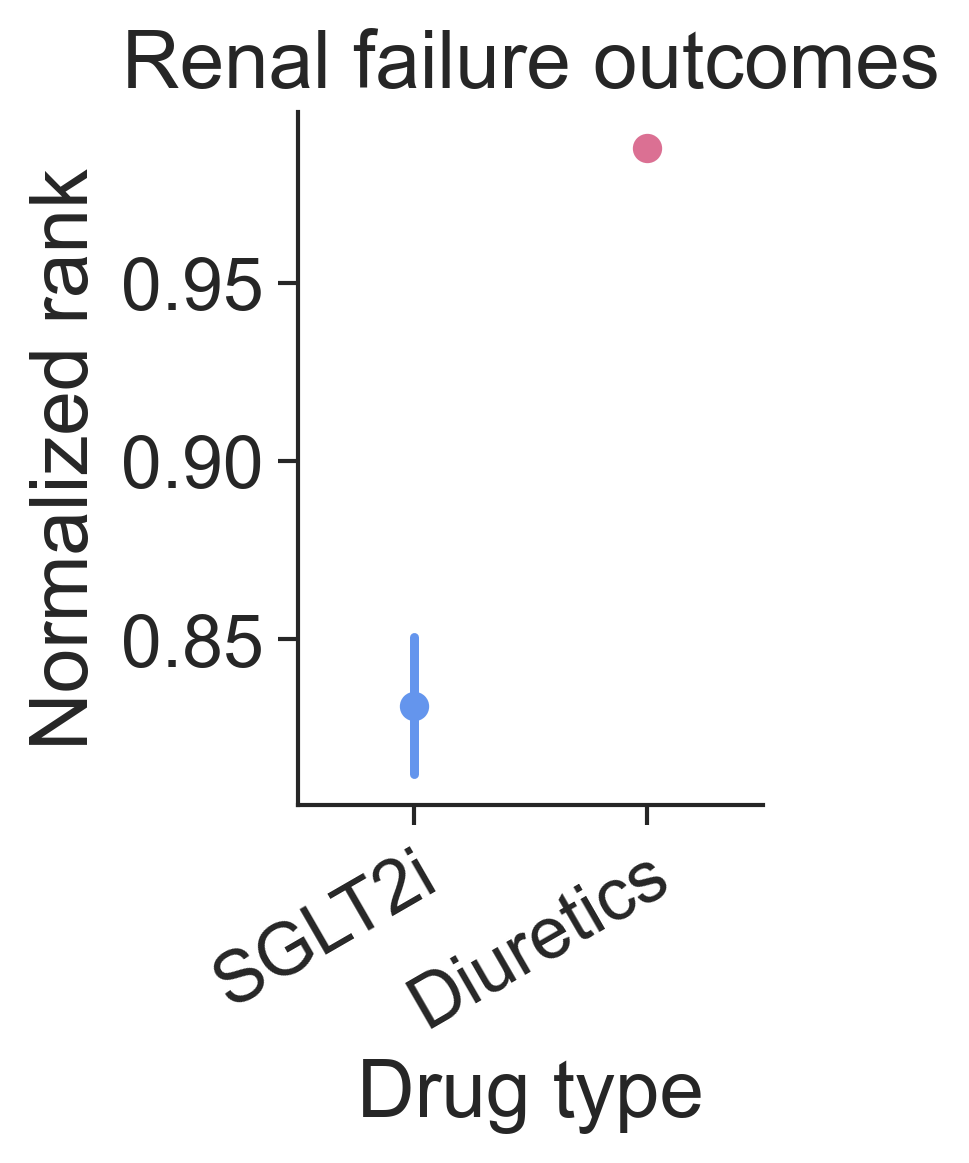

In [59]:
good_col = "cornflowerblue"
bad_col = "palevioletred"

plt.figure(figsize=(2, 3), dpi=300)
sns.set(style="ticks", context="paper", font_scale=2)
sns.pointplot(
    data=plot_data, y='Renal failure outcome', x='drug_class', 
    hue="drug_class", 
    palette={"SGLT2i":good_col, "Diuretics":bad_col},
    estimator=gmean, linestyles='none')
plt.title('Renal failure outcomes')
plt.ylabel('Normalized rank')
plt.xlabel('Drug type')
# plt.ylim(0.95, 1)
plt.xticks(rotation=30, rotation_mode="anchor", ha="right", )
sns.despine()
plt.savefig("./fig6_t2d+hf_renal_failure_score.svg", format="svg", dpi=300)

plt.show()

In [ ]:
mannwhitneyu(
    plot_data.query("drug_class == 'Diuretics'")["Renal failure outcome"].values, 
    plot_data.query("drug_class == 'SGLT2i'")["Renal failure outcome"].values, 
    alternative="greater",
)

MannwhitneyuResult(statistic=157233.0, pvalue=1.881899704301859e-97)

#### Renal (general)

In [60]:
t2d_sglt2i_df_filtered_rational_kidney = t2d_sglt2i_df_filtered_rational[t2d_sglt2i_df_filtered_rational["organ"].apply(lambda lst: "kidney" in lst)]
t2d_sglt2i_df_filtered_rational_kidney = t2d_sglt2i_df_filtered_rational_kidney.groupby(by=["drug_1", "drug_2"]).agg(list).drop(columns=["organ"]).reset_index()
t2d_sglt2i_df_filtered_rational_kidney["highest_5_mean"] = t2d_sglt2i_df_filtered_rational_kidney["value"].apply(
    lambda lst: np.mean(np.partition(lst, len(lst)-5)[-5:]))

t2d_diuretic_df_filtered_rational_kidney = t2d_diuretic_df_filtered_rational[t2d_diuretic_df_filtered_rational["organ"].apply(lambda lst: "kidney" in lst)]
t2d_diuretic_df_filtered_rational_kidney = t2d_diuretic_df_filtered_rational_kidney.groupby(by=["drug_1", "drug_2"]).agg(list).drop(columns=["organ"]).reset_index()
t2d_diuretic_df_filtered_rational_kidney["highest_5_mean"] = t2d_diuretic_df_filtered_rational_kidney["value"].apply(
    lambda lst: np.mean(np.partition(lst, len(lst)-5)[-5:]))

In [61]:
t2d_sglt2i_df_filtered_rational_kidney["drug_class"] = "SGLT2i"
t2d_diuretic_df_filtered_rational_kidney["drug_class"] = "Diuretics"

plot_data = pd.concat([
    t2d_sglt2i_df_filtered_rational_kidney,
    t2d_diuretic_df_filtered_rational_kidney,
], axis=0)

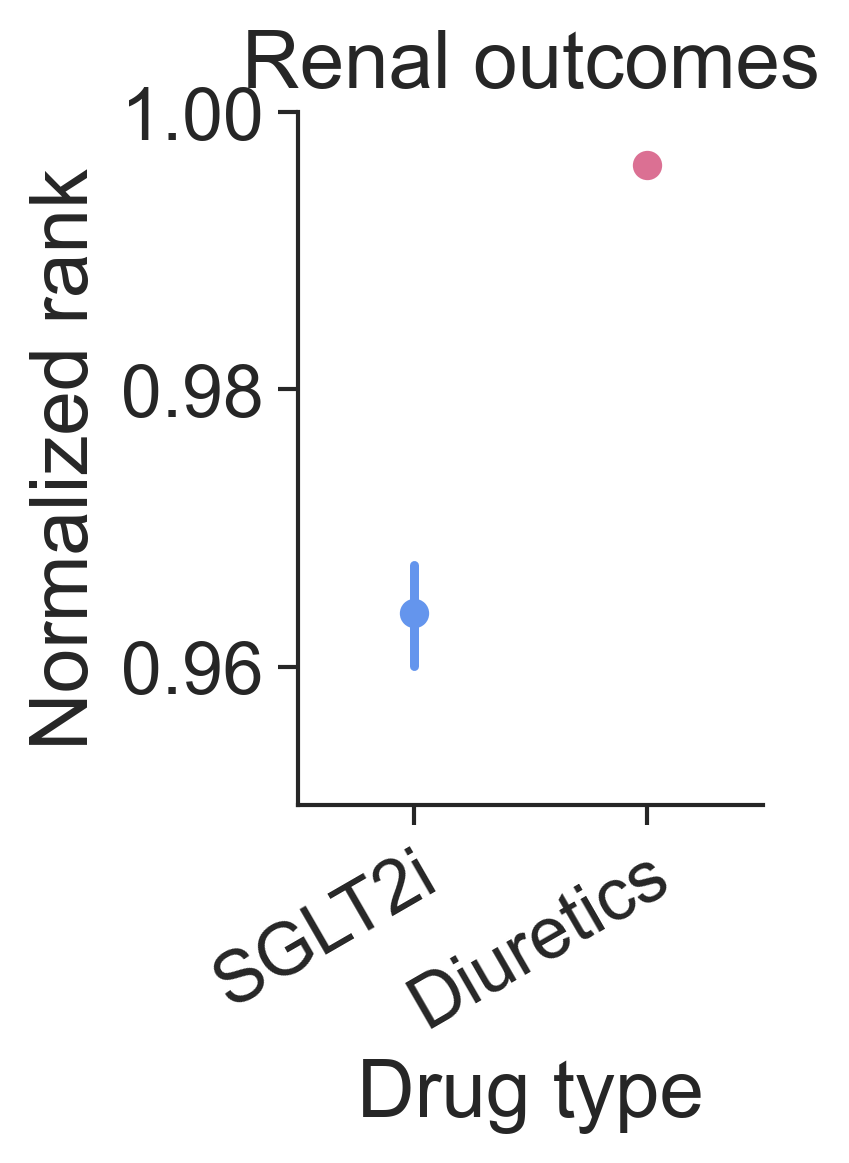

In [63]:
good_col = "cornflowerblue"
bad_col = "palevioletred"

plt.figure(figsize=(2, 3), dpi=300)
sns.set(style="ticks", context="paper", font_scale=2)
sns.pointplot(
    data=plot_data, y='highest_5_mean', x='drug_class', 
    hue="drug_class", 
    palette={"SGLT2i":good_col, "Diuretics":bad_col},
    estimator=gmean, linestyles='none')
plt.title('Renal outcomes')
plt.ylabel('Normalized rank')
plt.xlabel('Drug type')
plt.ylim(0.95, 1)
plt.xticks(rotation=30, rotation_mode="anchor", ha="right", )
sns.despine()
plt.savefig("./fig6_t2d+hf_renal_outcomes.svg", format="svg", dpi=300)

plt.show()

In [ ]:
mannwhitneyu(
    plot_data.query("drug_class == 'Diuretics'")["highest_5_mean"].values, 
    plot_data.query("drug_class == 'SGLT2i'")["highest_5_mean"].values, 
    alternative="greater",
)

MannwhitneyuResult(statistic=156064.5, pvalue=1.881617381760268e-94)

# T2D + MASH

Curation from https://www.cghjournal.org/article/S1542-3565(23)00265-3/fulltext

In [64]:
nash_drugs_clinical_trials = {
    "Current": {
        "Weight loss": ["Orlistat", "Phentermine", "Topiramate", "Bupropion", "Naltrexone"],
        "PPAR agonist": ["Pioglitazone"],
        "Anti-oxidant": ["Vitamin E"],
    },
    "Phase 3": {
        "FXR agonist": ["Obeticholic acid"],
        "THRβ agonist": ["MGL-3196"],  # resmetirom
        "PPAR agonist": ["Lanifibranor"],
        "GLP1 RA": ["Semaglutide"]
    },
    "Phase 2": {
        "FGFR agonist": ["FGF21", "Efruxifermin", "Pegozafermin", "FGF19"],
        "FXR agonist": ["Tropifexor", "Vonafexor", "TERN-101"],
        "PPAR agonist": ["Elafibranor", "Saroglitazar"],
        "THRβ agonist": ["VK-2809"],
        "Acetyl-CoA carboxylase inhibitor": ["Firsocostat", "Clesacostat"],  # clesacostat == PF-05221304
        "Fatty acid synthase inhibitor": ["Denifanstat", "ION224"],  # FASN inhibitor; DGAT2 inhibitor
        "Mitochondria": ["MSDC-0602K", "Azemiglitazone", "PXL065", "HU6"],  # plx065 (Deuterium-modified thiazolidinedione)?
        "Galectin-3 inhibitor": ["Belapectin"],
        "GLP1 RA": ["Tirzepatide", "Pemvidutide", "Cotadutide", "BI456906"],
        "Cyclophilin inhibitor": ["Rencofilstat"],
        "HSD17B13": ["GSK4532990"], 
        "Others": ["Icosabutate", "Norursodeoxycholic acid"],  # Nor-ursodeoxycholic acid
    }
}

all_nash_drugs_clinical_trials_names = sum([sum(list(val.values()), start=[]) for val in nash_drugs_clinical_trials.values()], start=[])
all_nash_drugs_clinical_trials_names = [drug.lower().replace("-", "").replace(" ", "") for drug in all_nash_drugs_clinical_trials_names]
set(all_nash_drugs_clinical_trials_names) - set(drug_metadata_nash["node_name"].dropna().str.lower().str.replace("-", "").str.replace(" ", "").values)

{'belapectin',
 'bi456906',
 'efruxifermin',
 'fgf19',
 'fgf21',
 'gsk4532990',
 'hu6',
 'ion224',
 'msdc0602k',
 'pegozafermin',
 'pemvidutide',
 'tirzepatide'}

Unmapped:
- Belapectin (GR-MD-02) is too new, and it does not have SMILES in DrugBank (and so was filtered out).
- Exenatide and liraglutide are peptides.
- FGF-19 and FGF-21 are proteins
- IMM-124E is composed of IgG
- Simtuzumab is an antibody.
- BI-456906 (Survodutide) is a peptide under development (not in DrugBank)
- Efruxifermin is a peptide under development (not in DrugBank)
- GSK4532990 is an RNAi
- ION224, HU6's structures are not available publicly
- MSDC-0602K is not in drugbank
- pegozafermin, pemvidutide, tirzepatide are peptide


Consider adding in:

- Denifanstat
- Clesacostat (PF-05221304) 
- Ervogastat (PF-06865571)
- Rencofilstat
- Vonafexor
- PXL065 is deuterium-stabilized (R)-pioglitazone and is not in drugbank

In [65]:
nash_drugs_clinical_trials_filtered = {phase:{
    moa: [
        drug for drug in drugs 
        if drug.lower().replace("-", "").replace(" ", "") in drug_metadata_nash["node_name"].dropna().str.lower().str.replace("-", "").str.replace(" ", "").values
    ] for moa, drugs in drug_dict.items() 
    if set([drug.lower().replace("-", "").replace(" ", "") for drug in drugs]) & set(drug_metadata_nash["node_name"].dropna().str.lower().str.replace("-", "").str.replace(" ", "").values) != set()
} for phase, drug_dict in nash_drugs_clinical_trials.items()}

pprint(nash_drugs_clinical_trials_filtered)

{'Current': {'Anti-oxidant': ['Vitamin E'],
             'PPAR agonist': ['Pioglitazone'],
             'Weight loss': ['Orlistat',
                             'Phentermine',
                             'Topiramate',
                             'Bupropion',
                             'Naltrexone']},
 'Phase 2': {'Acetyl-CoA carboxylase inhibitor': ['Firsocostat', 'Clesacostat'],
             'Cyclophilin inhibitor': ['Rencofilstat'],
             'FXR agonist': ['Tropifexor', 'Vonafexor', 'TERN-101'],
             'Fatty acid synthase inhibitor': ['Denifanstat'],
             'GLP1 RA': ['Cotadutide'],
             'Mitochondria': ['Azemiglitazone', 'PXL065'],
             'Others': ['Icosabutate', 'Norursodeoxycholic acid'],
             'PPAR agonist': ['Elafibranor', 'Saroglitazar'],
             'THRβ agonist': ['VK-2809']},
 'Phase 3': {'FXR agonist': ['Obeticholic acid'],
             'GLP1 RA': ['Semaglutide'],
             'PPAR agonist': ['Lanifibranor'],
             'TH

In [66]:
nash_drugs_clinical_trials_filtered_df = pd.melt(
    pd.DataFrame.from_dict(nash_drugs_clinical_trials_filtered, orient="columns").reset_index(names=["moa"]), 
    id_vars=["moa"], value_name="drugs", var_name="phase"
).dropna().explode(column=["drugs"]).reset_index(drop=True)
nash_drugs_clinical_trials_filtered_df["drugs_renamed"] = nash_drugs_clinical_trials_filtered_df["drugs"].str.lower()
nash_drugs_clinical_trials_filtered_df["drug_ind"] = nash_drugs_clinical_trials_filtered_df["drugs_renamed"].apply(lambda x: drug_name_to_ind_nash[x])
nash_drugs_clinical_trials_filtered_df = nash_drugs_clinical_trials_filtered_df.drop(columns=["drugs_renamed"])
display(nash_drugs_clinical_trials_filtered_df)

nash_drug_clinical_trials_to_moa = nash_drugs_clinical_trials_filtered_df[["drugs", "moa"]].set_index("drugs").to_dict()["moa"]
nash_drug_clinical_trials_to_moa = {k.lower():v for k, v in nash_drug_clinical_trials_to_moa.items()}
nash_drug_clinical_trials_to_phase = nash_drugs_clinical_trials_filtered_df[["drugs", "phase"]].set_index("drugs").to_dict()["phase"]
nash_drug_clinical_trials_to_phase = {k.lower():v for k, v in nash_drug_clinical_trials_to_phase.items()}

,moa,phase,drugs,drug_ind
0,Weight loss,Current,Orlistat,720
1,Weight loss,Current,Phentermine,139
2,Weight loss,Current,Topiramate,195
3,Weight loss,Current,Bupropion,763
4,Weight loss,Current,Naltrexone,477
5,PPAR agonist,Current,Pioglitazone,749
6,Anti-oxidant,Current,Vitamin E,127
7,PPAR agonist,Phase 3,Lanifibranor,10470
8,FXR agonist,Phase 3,Obeticholic acid,1865
9,THRβ agonist,Phase 3,MGL-3196,9921


## MASH drugs from the Clinical Trials Landscape paper

In [67]:
_, t2d_nash_landscape_df_filtered = get_comorb_drugs_data_for_one_comorb_known_drugs(
    d1_drugs, d1_name, nash_drugs_clinical_trials_filtered_df["drugs"].str.lower().values, "MASH",
    drug_metadata_nash, normalized_rank_drugbank, ddi_classes, to_delete_classes, drug_ind_to_name,
)

overlap
overlap


In [68]:
t2d_nash_landscape_df_filtered_rational = t2d_nash_landscape_df_filtered[t2d_nash_landscape_df_filtered.index.map(
    lambda x: True if t2d_drug_moas[x.split("; ")[-2]] != nash_drug_clinical_trials_to_moa[x.split("; ")[-1]] else False)]
t2d_nash_landscape_df_filtered_rational = pd.melt(t2d_nash_landscape_df_filtered_rational.reset_index(), 
                                                  id_vars=t2d_nash_landscape_df_filtered_rational.index.name, var_name="ddi_class")
t2d_nash_landscape_df_filtered_rational[["temp_1", "temp_2", "drug_1", "drug_2"]] = (
    t2d_nash_landscape_df_filtered_rational["(Disease 1; Disease 2; Drug 1; Drug 2)"].str.split("; ", expand=True))
t2d_nash_landscape_df_filtered_rational = t2d_nash_landscape_df_filtered_rational.drop(columns=["temp_1", "temp_2", "(Disease 1; Disease 2; Drug 1; Drug 2)"])
t2d_nash_landscape_df_filtered_rational = t2d_nash_landscape_df_filtered_rational.merge(organs_csv, on="ddi_class", how="left")
t2d_nash_landscape_df_filtered_rational["organ"] = t2d_nash_landscape_df_filtered_rational["organ"].str.split(", ")

t2d_nash_landscape_df_filtered_rational_organ = t2d_nash_landscape_df_filtered_rational.explode(column="organ").query("organ in @organs_of_interest")
t2d_nash_landscape_df_filtered_rational_wide = pd.pivot_table(t2d_nash_landscape_df_filtered_rational, values="value", 
                                                              index=["drug_1", "drug_2"], columns="ddi_class").reset_index()

t2d_nash_landscape_df_filtered_rational_grouped = t2d_nash_landscape_df_filtered_rational.groupby(by=["drug_1", "drug_2"]).agg(list).reset_index()
t2d_nash_landscape_df_filtered_rational_grouped[["highest_5_ddi_classes", "highest_5_scores"]] = pd.DataFrame(
    t2d_nash_landscape_df_filtered_rational_grouped[["ddi_class", "value"]].apply(
        lambda row: [np.array(row[0])[np.argpartition(row[1], len(row[1])-5)[-5:]], 
                     np.partition(row[1], len(row[1])-5)[-5:]], axis=1
    ).to_list(), columns=["highest_5_ddi_classes", "highest_5_scores"])
t2d_nash_landscape_df_filtered_rational_grouped["highest_5_mean"] = t2d_nash_landscape_df_filtered_rational_grouped["highest_5_scores"].apply(np.mean)

In [72]:
plot_data = t2d_nash_landscape_df_filtered_rational_grouped.groupby("drug_2").agg(list).reset_index()
plot_data["lowest_5_highest_5_mean"] = plot_data["highest_5_mean"].apply(lambda lst: np.mean(np.partition(lst, 5)[:5]))
plot_data["median_highest_5_mean"] = plot_data["highest_5_mean"].apply(np.median)
plot_data["average_highest_5_mean"] = plot_data["highest_5_mean"].apply(np.mean)

plot_data["NASH_drug_category"] = plot_data["drug_2"].apply(lambda x: nash_drug_clinical_trials_to_moa[x])
plot_data["NASH_drug_phase"] = plot_data["drug_2"].apply(lambda x: nash_drug_clinical_trials_to_phase[x])

plot_data["NASH_drug_category"] = (
    plot_data["NASH_drug_category"].
    replace({"Acetyl-CoA carboxylase inhibitor":"ACC inhibitor", "Fatty acid synthase inhibitor":"FAS inhibitor"})
)

plot_data = plot_data.query("NASH_drug_category != 'Others'")

/tmp/ipykernel_1095280/3767985721.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data,


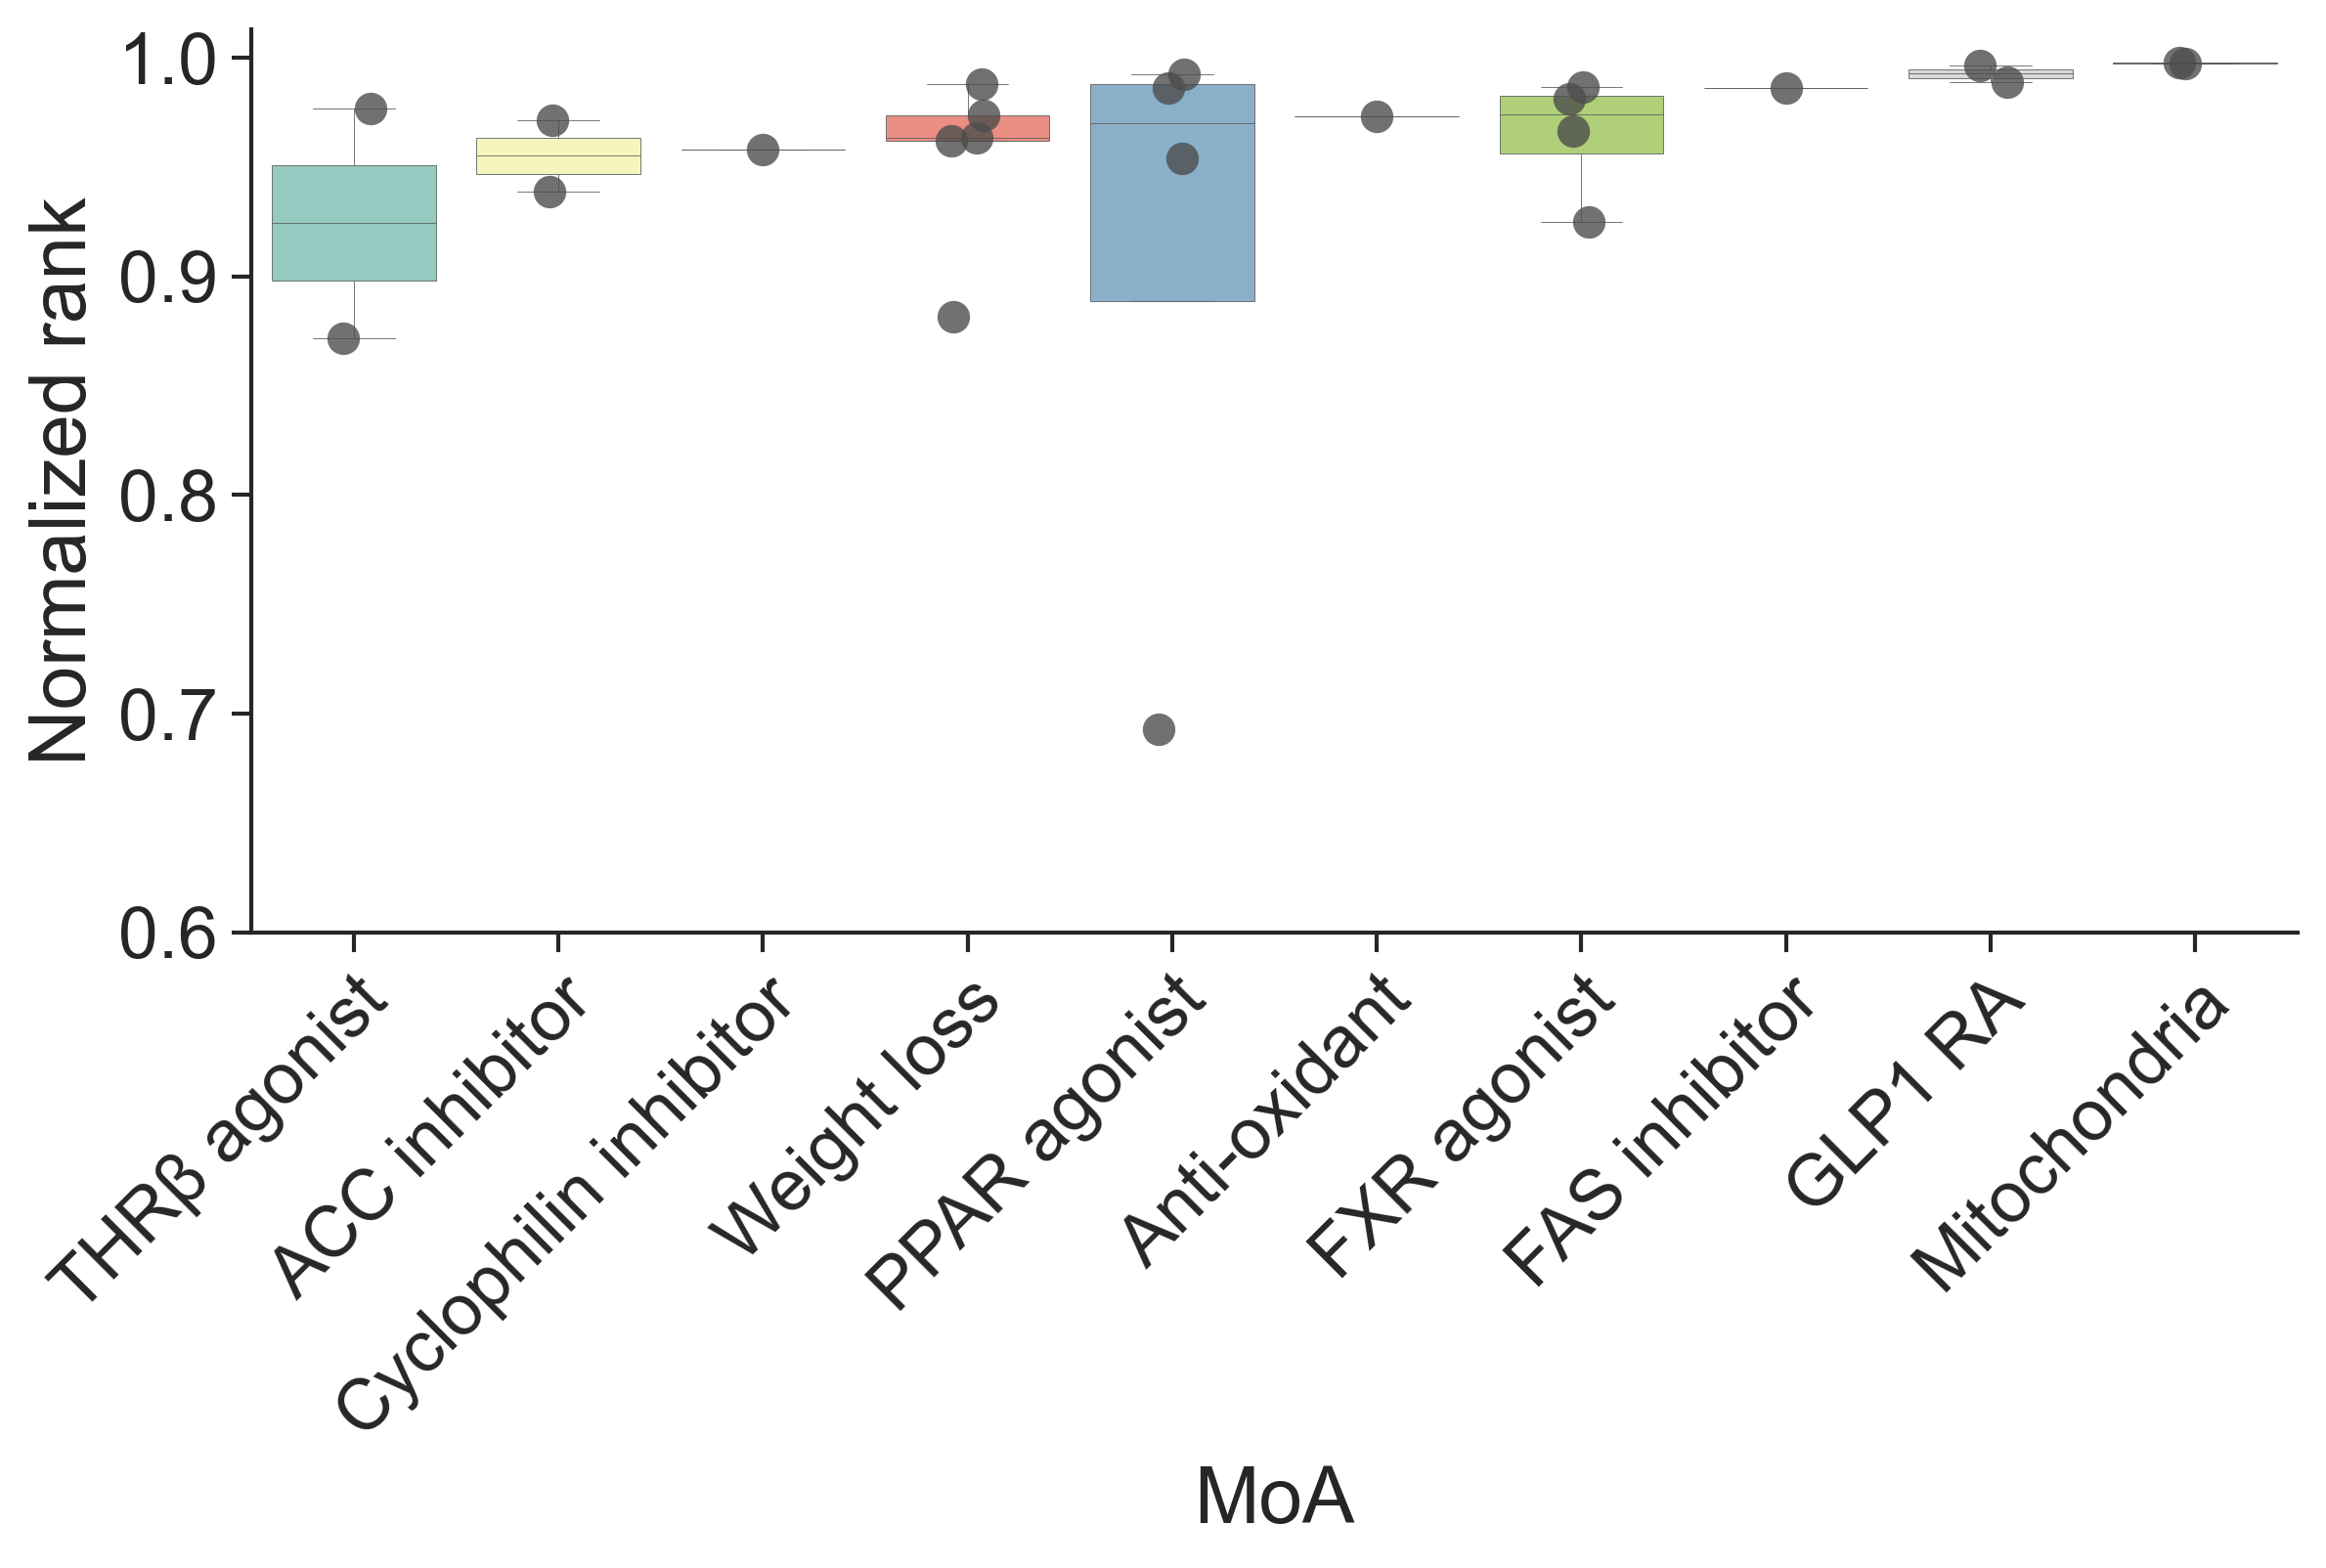

In [75]:
metric = "lowest_5_highest_5_mean"

temp = plot_data.groupby("NASH_drug_category").agg(list)
temp["agg_score"] = temp[metric].apply(np.median)
order = temp.sort_values("agg_score").index.values

plt.figure(figsize=(9, 4), dpi=300)
sns.set(style="ticks", context="paper", font_scale=2)
sns.boxplot(data=plot_data, 
            x="NASH_drug_category", y=metric, palette="Set3", width=.8, order=order, showfliers=False, 
            boxprops={"linewidth":0.2}, medianprops={"linewidth":0.2}, capprops={"linewidth":0.2}, whiskerprops={"linewidth":0.2},
           )
sns.stripplot(data=plot_data, 
              x="NASH_drug_category", y=metric, size=8, color=".3", dodge=True, order=order, alpha=.8)
# sns.despine(top=True, right=True, left=False, bottom=False, offset=None, trim=True)
sns.despine()
plt.xlabel("MoA")
plt.ylabel("Normalized rank")
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.ylim(0.6)

plt.savefig("./fig6_nash+t2d_straified_nash_drug_category_inverted.svg", format="svg", dpi=300)
plt.show()

/tmp/ipykernel_1095280/2052064302.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data,


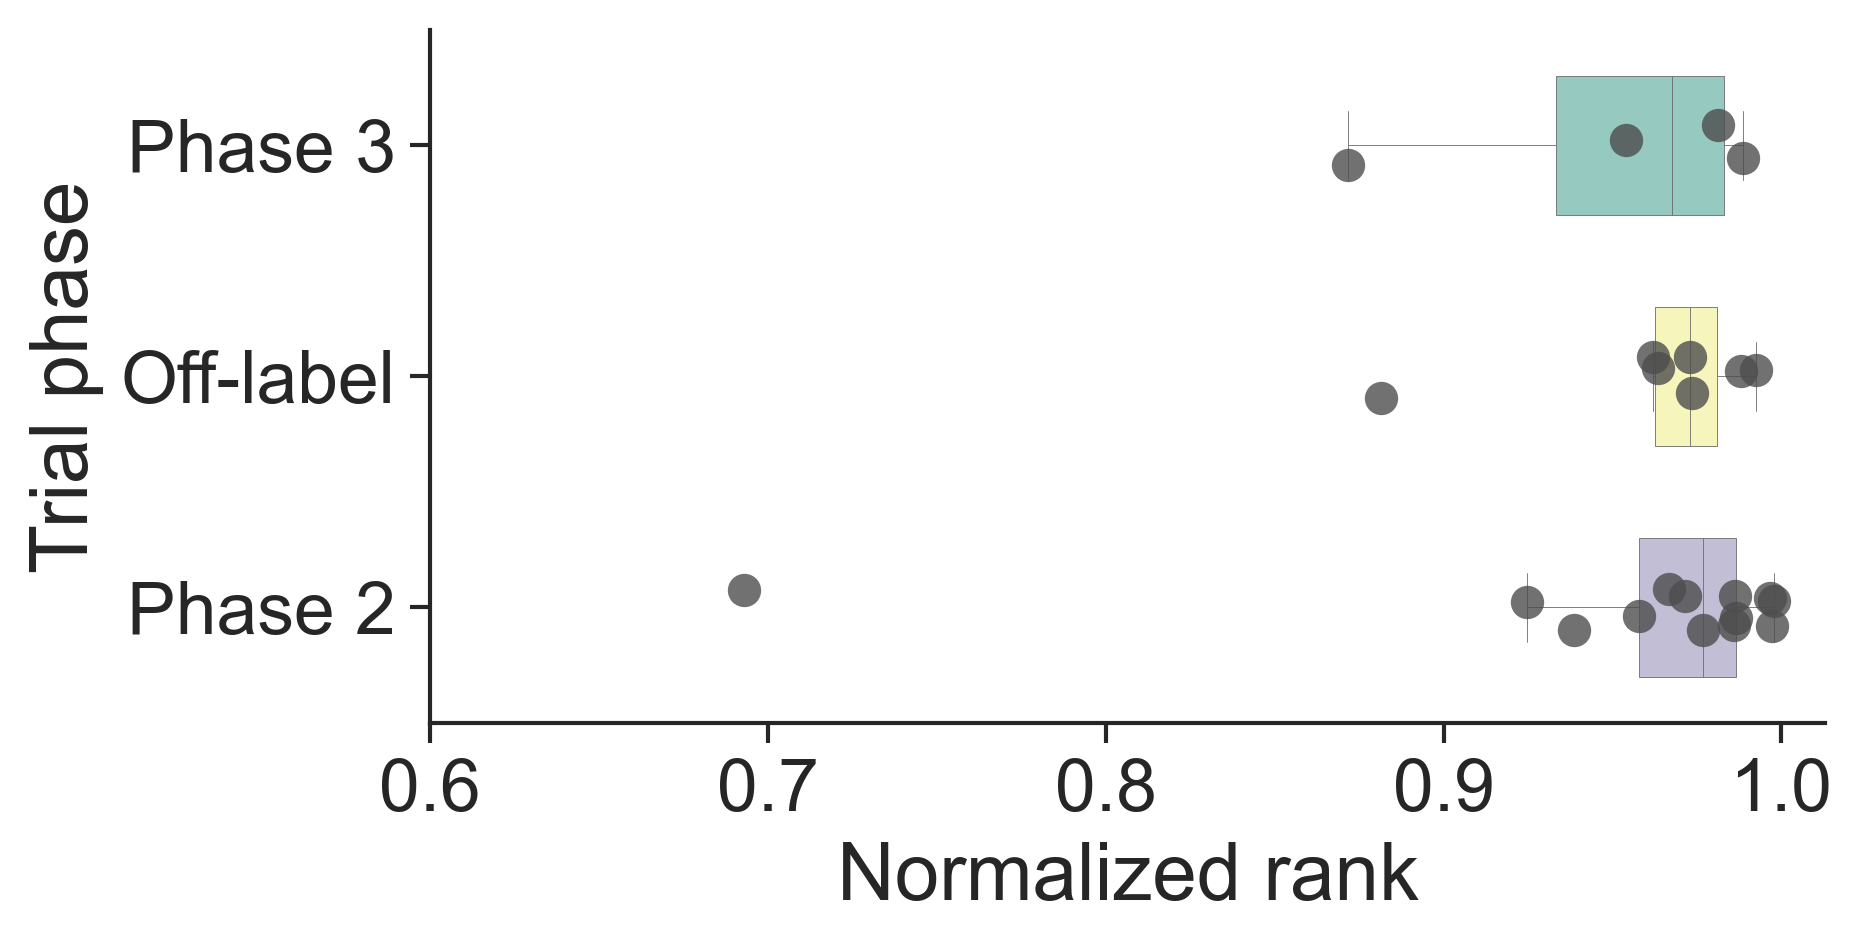

In [76]:
plot_data["NASH_drug_phase"] = (
    plot_data["NASH_drug_phase"].replace({"Current":"Off-label"})
)

temp = plot_data.groupby("NASH_drug_phase").agg(list)
temp["agg_score"] = temp[metric].apply(np.median)
order = temp.sort_values("agg_score").index.values

plt.figure(figsize=(6, 3), dpi=300)
sns.set(style="ticks", context="paper", font_scale=2)
sns.boxplot(data=plot_data, 
            y="NASH_drug_phase", x=metric, palette="Set3", width=.6, order=order, showfliers=False,
            boxprops={"linewidth":0.2}, medianprops={"linewidth":0.2}, capprops={"linewidth":0.2}, whiskerprops={"linewidth":0.2},
            )
sns.stripplot(data=plot_data, 
              y="NASH_drug_phase", x=metric, size=8, color=".3", dodge=True, order=order, alpha=.8)
sns.despine()
plt.ylabel("Trial phase")
plt.xlabel("Normalized rank")
# plt.xticks(rotation=45)
plt.xlim(0.6)

plt.savefig("./fig6_nash+t2d_straified_nash_drug_phase.svg", format="svg", dpi=300)
plt.show()

In [77]:
plot_data[["drug_2", metric, "NASH_drug_phase", "NASH_drug_category"]].sort_values("lowest_5_highest_5_mean").reset_index(drop=True)

,drug_2,lowest_5_highest_5_mean,NASH_drug_phase,NASH_drug_category
0,elafibranor,0.693021,Phase 2,PPAR agonist
1,mgl-3196,0.871755,Phase 3,THRβ agonist
2,orlistat,0.881332,Off-label,Weight loss
3,tropifexor,0.924686,Phase 2,FXR agonist
4,firsocostat,0.938657,Phase 2,ACC inhibitor
5,lanifibranor,0.953858,Phase 3,PPAR agonist
6,rencofilstat,0.957690,Phase 2,Cyclophilin inhibitor
7,phentermine,0.961966,Off-label,Weight loss
8,naltrexone,0.963315,Off-label,Weight loss
9,tern-101,0.966604,Phase 2,FXR agonist


## Connecting with clinical trials

Get drugs in CTs from OpenTargets

In [78]:
# EFO_0003095 drugs from OpenTargets
known_drugs = pd.read_csv("./EFO_0003095-known-drugs.tsv", sep="\t")[["diseaseName", "drugId", "drugName", "phase", "status", "source"]].drop_duplicates()
known_drugs["drugName"] = known_drugs["drugName"].str.lower().str.replace("mt-3995", "apararenone")  # for mapping purpose
chembl_drugbank_mapping = pd.read_table("./chembl_drugbank_mapping.txt", sep="\t").rename(columns={"ChEMBL":"drugId", "DrugBank":"drugbank_id"})

# Map ChEMBL IDs to DrugBank IDs
known_drugs = (
    known_drugs.merge(chembl_drugbank_mapping, on="drugId", how="left").
    merge(
        drug_metadata_nash.reset_index()[["index", "node_id"]].dropna(subset=["node_id"]).rename(columns={"node_id":"drugbank_id", "index":"drug_ind"}), 
        on="drugbank_id", how="left"
    )
)
print(known_drugs["diseaseName"].unique())

known_drugs["source"] = known_drugs["source"].str.split(",")
print((known_drugs["source"].apply(len) > 1).sum())
known_drugs = known_drugs.explode("source")

['non-alcoholic fatty liver disease' 'non-alcoholic steatohepatitis']
21


In [79]:
temp = drug_metadata_nash[["cmap_name", "node_name"]].apply(
    lambda row: 
    set(
        ([drug_name.lower() for drug_name in row[0]] if row[0] == row[0] else []) + \
        ([row[1].lower()] if row[1] == row[1] else [])
    ), axis=1
)

print(len(set(known_drugs[known_drugs["drug_ind"].isna()]["drugName"].values) - set.union(*temp.values)))
set(known_drugs[known_drugs["drug_ind"].isna()]["drugName"].values) - set.union(*temp.values)

20


{'aldafermin',
 'atorvastatin calcium',
 'belapectin',
 'chiglitazar',
 'efinopegdutide',
 'exenatide',
 'fazpilodemab',
 'insulin',
 'insulin glargine',
 'k-877',
 'leronlimab',
 'liraglutide',
 'losartan potassium',
 'metreleptin',
 'muromonab-cd3',
 'pegbelfermin',
 'pioglitazone hydrochloride',
 'rosiglitazone maleate',
 'somatropin',
 'tirzepatide'}

All are reasonably missing in our metadata (either because they're peptide/proteins, or their other derivatives are in our metadata).

In [80]:
unmapped = known_drugs[known_drugs["drug_ind"].isna()]
unmapped["drug_ind"] = unmapped["drugName"].apply(lambda name: temp[temp.apply(lambda names: name in names)].index.values)
unmapped["drug_ind"] = unmapped["drug_ind"].apply(lambda x: np.nan if len(x) == 0 else x[0])
known_drugs = pd.concat([
    unmapped[~unmapped["drug_ind"].isna()],
    known_drugs[~known_drugs["drug_ind"].isna()],
], axis=0)
known_drugs["drugbank_id"] = known_drugs[["drugbank_id", "drug_ind"]].apply(lambda row: row[0] if row[0] == row[0] else drug_metadata_nash.loc[row[1], "node_id"], axis=1)
known_drugs = known_drugs.drop_duplicates(subset=["diseaseName", "drugName", "phase", "status", "source", "drugbank_id", "drug_ind"])
assert known_drugs[known_drugs["drugbank_id"].isna()]["drugName"].nunique() == 1  # clesacostat

known_drugs["drugName"] = (
    known_drugs["drugName"].
    replace("resmetirom", "mgl-3196").replace("betaine", "glycine betaine").
    replace("ursodiol", "ursodeoxycholic acid").replace("ethinyl estradiol", "ethinylestradiol").replace("mb07811", "vk-2809")
)

known_drugs_grouped = known_drugs.groupby(by=["drug_ind"]).agg(list)

# make sure we now have a clean ChEMBL-DrugBank-Name mapping
assert known_drugs_grouped["drugId"].apply(lambda lst: len(set(lst)) > 1).sum() == 0
assert known_drugs_grouped["drugName"].apply(lambda lst: len(set(lst)) > 1).sum() == 0
assert known_drugs_grouped["drugbank_id"].apply(lambda lst: len(set(lst)) > 1).sum() == 0

known_drugs_grouped = known_drugs_grouped.drop(columns=["drugId"])
known_drugs_grouped["drugName"] = known_drugs_grouped["drugName"].apply(lambda lst: lst[0])
known_drugs_grouped["drugbank_id"] = known_drugs_grouped["drugbank_id"].apply(lambda lst: lst[0])

known_drugs_grouped_filtered = known_drugs[known_drugs["status"] != "Terminated"].groupby(by=["drug_ind"]).agg(list)

# make sure we now have a clean ChEMBL-DrugBank-Name mapping
assert known_drugs_grouped_filtered["drugId"].apply(lambda lst: len(set(lst)) > 1).sum() == 0
assert known_drugs_grouped_filtered["drugName"].apply(lambda lst: len(set(lst)) > 1).sum() == 0
assert known_drugs_grouped_filtered["drugbank_id"].apply(lambda lst: len(set(lst)) > 1).sum() == 0

known_drugs_grouped_filtered = known_drugs_grouped_filtered.drop(columns=["drugId"])
known_drugs_grouped_filtered["drugName"] = known_drugs_grouped_filtered["drugName"].apply(lambda lst: lst[0])
known_drugs_grouped_filtered["drugbank_id"] = known_drugs_grouped_filtered["drugbank_id"].apply(lambda lst: lst[0])

/tmp/ipykernel_1095280/3365288097.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unmapped["drug_ind"] = unmapped["drugName"].apply(lambda name: temp[temp.apply(lambda names: name in names)].index.values)
/tmp/ipykernel_1095280/3365288097.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unmapped["drug_ind"] = unmapped["drug_ind"].apply(lambda x: np.nan if len(x) == 0 else x[0])


In [81]:
_, t2d_nash_ot_df_filtered = get_comorb_drugs_data_for_one_comorb_known_drugs(
    d1_drugs, d1_name, known_drugs_grouped["drugName"], "NASH",
    drug_metadata_nash, normalized_rank_drugbank, ddi_classes, to_delete_classes, drug_ind_to_name,
)

overlap
overlap
overlap
overlap
overlap
overlap
overlap
overlap
overlap
overlap


In [82]:
t2d_nash_ot_df_filtered = t2d_nash_ot_df_filtered[t2d_nash_ot_df_filtered.index.map(
    lambda x: True if not ((x.split("; ")[-1] in t2d_drug_moas.keys()) and (t2d_drug_moas[x.split("; ")[-2]] == t2d_drug_moas[x.split("; ")[-1]])) else False)]
t2d_nash_ot_df_filtered = pd.melt(t2d_nash_ot_df_filtered.reset_index(), 
                                  id_vars=t2d_nash_ot_df_filtered.index.name, var_name="ddi_class")
t2d_nash_ot_df_filtered[["temp_1", "temp_2", "drug_1", "drug_2"]] = (
    t2d_nash_ot_df_filtered["(Disease 1; Disease 2; Drug 1; Drug 2)"].str.split("; ", expand=True))
t2d_nash_ot_df_filtered = t2d_nash_ot_df_filtered.drop(columns=["temp_1", "temp_2", "(Disease 1; Disease 2; Drug 1; Drug 2)"])
t2d_nash_ot_df_filtered = t2d_nash_ot_df_filtered.merge(organs_csv, on="ddi_class", how="left")
t2d_nash_ot_df_filtered["organ"] = t2d_nash_ot_df_filtered["organ"].str.split(", ")

t2d_nash_ot_df_filtered_organ = t2d_nash_ot_df_filtered.explode(column="organ").query("organ in @organs_of_interest")
t2d_nash_ot_df_filtered_wide = pd.pivot_table(t2d_nash_ot_df_filtered, values="value", 
                                                              index=["drug_1", "drug_2"], columns="ddi_class").reset_index()

t2d_nash_ot_df_filtered_grouped = t2d_nash_ot_df_filtered.groupby(by=["drug_1", "drug_2"]).agg(list).reset_index()
t2d_nash_ot_df_filtered_grouped[["highest_5_ddi_classes", "highest_5_scores"]] = pd.DataFrame(
    t2d_nash_ot_df_filtered_grouped[["ddi_class", "value"]].apply(
        lambda row: [np.array(row[0])[np.argpartition(row[1], len(row[1])-5)[-5:]], 
                     np.partition(row[1], len(row[1])-5)[-5:]], axis=1
    ).to_list(), columns=["highest_5_ddi_classes", "highest_5_scores"])
t2d_nash_ot_df_filtered_grouped["highest_5_mean"] = t2d_nash_ot_df_filtered_grouped["highest_5_scores"].apply(np.mean)
t2d_nash_ot_df_filtered_grouped

,drug_1,drug_2,ddi_class,value,organ,highest_5_ddi_classes,highest_5_scores,highest_5_mean
0,acarbose,amlodipine,"[CNS depression, hypotonia, increase, CNS depr...","[0.25444626808166504, 0.3448109030723572, 0.13...","[[others/general], [others/general], [endocrin...","[renal failure, hypotension, hyperkalemia, inc...","[0.9890096187591553, 0.9948395490646362, 0.990...",0.992668
1,acarbose,apararenone,"[CNS depression, hypotonia, increase, CNS depr...","[0.5928122997283936, 0.6388220191001892, 0.342...","[[others/general], [others/general], [endocrin...","[neutropenia, thrombocytopenia, increase, anti...","[0.9744641780853271, 0.9786428809165955, 0.982...",0.982823
2,acarbose,atorvastatin,"[CNS depression, hypotonia, increase, CNS depr...","[0.6350871324539185, 0.7661806344985962, 0.461...","[[others/general], [others/general], [endocrin...","[myopathic rhabdomyolysis, increase, neutropen...","[0.9434270262718201, 0.9742835760116577, 0.975...",0.972820
3,acarbose,caffeine,"[CNS depression, hypotonia, increase, CNS depr...","[0.9292597770690918, 0.9228982329368591, 0.652...","[[others/general], [others/general], [endocrin...","[neutropenia, thrombocytopenia, increase, cyto...","[0.9509997963905334, 0.9514641761779785, 0.991...",0.978603
4,acarbose,cenicriviroc,"[CNS depression, hypotonia, increase, CNS depr...","[0.6890654563903809, 0.8533061146736145, 0.637...","[[others/general], [others/general], [endocrin...","[fluid retention, vasopressor, increase, thera...","[0.9414980411529541, 0.9649614691734314, 0.970...",0.967771
...,...,...,...,...,...,...,...,...
2646,voglibose,tofogliflozin,"[CNS depression, hypotonia, increase, CNS depr...","[0.4693946838378906, 0.8114234209060669, 0.328...","[[others/general], [others/general], [endocrin...","[anticoagulant, increase, lactic acidosis, inc...","[0.9791826605796814, 0.9958526492118835, 0.996...",0.994108
2647,voglibose,tropifexor,"[CNS depression, hypotonia, increase, CNS depr...","[0.2038753181695938, 0.08680497854948044, 0.17...","[[others/general], [others/general], [endocrin...","[fluid retention, vasopressor, increase, hypog...","[0.9021096229553223, 0.9108753800392151, 0.946...",0.933226
2648,voglibose,ursodeoxycholic acid,"[CNS depression, hypotonia, increase, CNS depr...","[0.8084524869918823, 0.9447699785232544, 0.827...","[[others/general], [others/general], [endocrin...","[adverse effects, increase, hypercalcemia, inc...","[0.9808257818222046, 0.9860123991966248, 0.990...",0.988451
2649,voglibose,vk-2809,"[CNS depression, hypotonia, increase, CNS depr...","[0.8026177883148193, 0.8189713358879089, 0.508...","[[others/general], [others/general], [endocrin...","[anticoagulant, increase, neutropenia, thrombo...","[0.9668339490890503, 0.9769515991210938, 0.979...",0.980668


In [83]:
plot_data = t2d_nash_ot_df_filtered_grouped.groupby("drug_2").agg(list).reset_index()
plot_data["lowest_5_highest_5_mean"] = plot_data["highest_5_mean"].apply(lambda lst: np.mean(np.partition(lst, 5)[:5]))

known_drugs_grouped_filtered["maxPhase"] = known_drugs_grouped_filtered["phase"].apply(max)
known_drugs_grouped_filtered["maxPhase"] = known_drugs_grouped_filtered["maxPhase"].apply(lambda phase: phase if phase not in {2, 3, 4} else "Phase 2-4")
known_drugs_grouped_filtered["maxPhase"] = known_drugs_grouped_filtered["maxPhase"].apply(lambda phase: phase if phase not in {1} else "Phase 1")
nash_drug_to_ot_phase = known_drugs_grouped_filtered[["drugName", "maxPhase"]].set_index("drugName").to_dict()["maxPhase"]

plot_data["NASH_drug_phase"] = plot_data["drug_2"].apply(
    lambda x: nash_drug_to_ot_phase[x] if x in nash_drug_to_ot_phase.keys() else "Terminated only"
).astype(str)

/tmp/ipykernel_1095280/555469233.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, y="NASH_drug_phase", x=metric, palette="Set3",


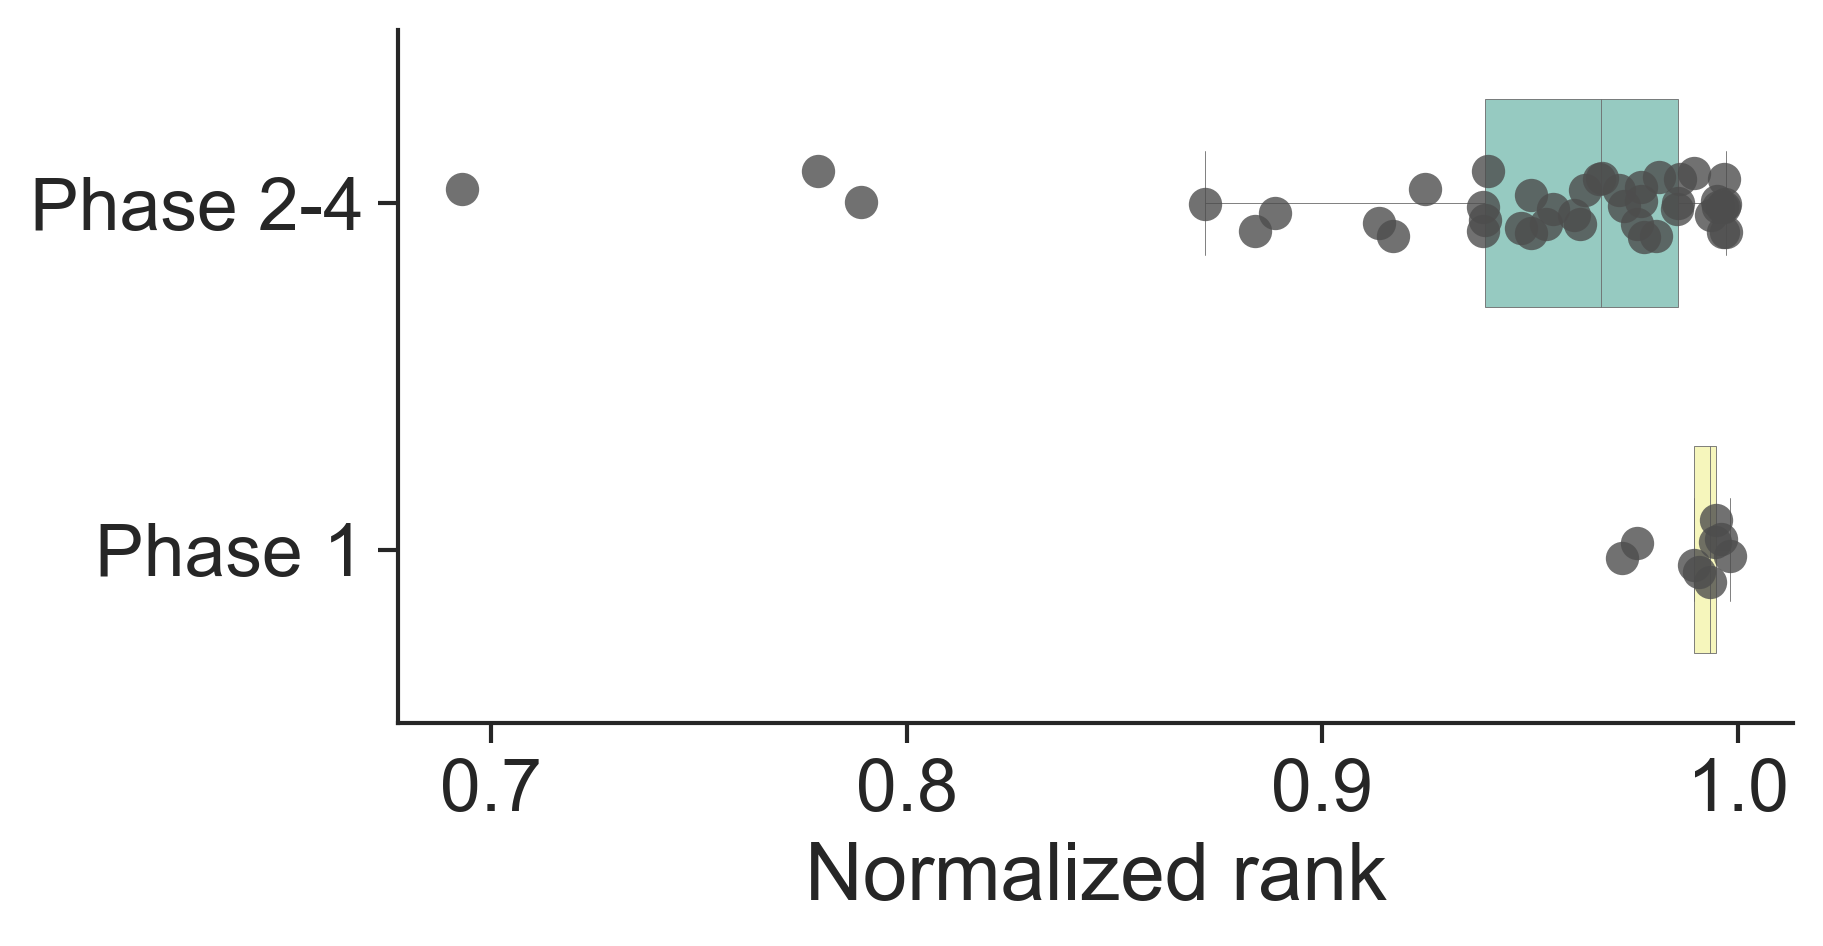

In [ ]:
plot_data = plot_data[plot_data["drug_1"].apply(len) == len(d1_drugs)].query("NASH_drug_phase != 'Terminated only'")  # because we skip duplicates
# plot_data = plot_data.query("NASH_drug_phase != 'Terminated only'")

metric = "lowest_5_highest_5_mean"

temp = plot_data.groupby("NASH_drug_phase").agg(list)
temp["agg_score"] = temp[metric].apply(np.median)
order = temp.sort_values("agg_score").index.values

plt.figure(figsize=(6, 3), dpi=300)
sns.set(style="ticks", context="paper", font_scale=2)
sns.boxplot(data=plot_data, y="NASH_drug_phase", x=metric, palette="Set3", 
            boxprops={"linewidth":0.2}, medianprops={"linewidth":0.2}, capprops={"linewidth":0.2}, whiskerprops={"linewidth":0.2},
            width=.6, order=order, showfliers=False)
sns.stripplot(data=plot_data, y="NASH_drug_phase", x=metric, 
              size=8, color=".3", dodge=True, order=order, alpha=.8)
sns.despine()
plt.ylabel("")
plt.xlabel("Normalized rank")
plt.savefig("./fig6_nash+t2d_straified_nash_drug_ot_phase.svg", format="svg", dpi=300)
plt.show()

Manually curate drug combinations currently in clinical development

In [29]:
# Collected from mainly a review (https://doi.org/10.1038/s41591-023-02242-6) and other sources
clinically_investigating_combos = [
    ["cenicriviroc", "tropifexor"],  # AbbVie & Norvatis (https://clinicaltrials.gov/study/NCT03517540)
    
    ["lipoic acid", "rosiglitazone"],  # Rosiglitazone (avandia) was withdrawn in 2010, https://clinicaltrials.gov/study/NCT01406704
    
    ["firsocostat", "licogliflozin"],
    ["cilofexor", "licogliflozin"],  # SGTL2i + (https://pubmed.ncbi.nlm.nih.gov/35439567/)
    
    ["cenicriviroc", "firsocostat"],
    ["cenicriviroc", "cilofexor"],  # FXR agonist + (CCR)2–CCR5 inhibitor (in that review)
    
    ["licogliflozin", "tropifexor"],  # FXR agonist + (SGLT)1–SGLT2 inhibitor (https://clinicaltrials.gov/ct2/show/NCT04065841)
    
    ["roflumilast", "pioglitazone"],  # https://clinicaltrials.gov/study/NCT01703260
    
    ["firsocostat", "cilofexor"],
    ["cilofexor", "selonsertib"],
    ["firsocostat", "selonsertib"],  # FXR agonist + ASK-1 inhibitor, ACC inhibitor (https://pubmed.ncbi.nlm.nih.gov/33169409/)
    
    # Good example of adding another drug to reduce side effect!
    # Drug combination may decrease side effects in two ways. First, drugs may have dose-dependent side effects and their use in combination may allow using 
    # lower doses to increase tolerability without compromising efficacy. Second, addition of a drug may be prescribed to mitigate the side effect of the first drug. 
    ["fenofibrate", "firsocostat"],  # ACC inhibitor (can cause hypertriglyceridaemia) + fenofibrate (https://clinicaltrials.gov/study/NCT02781584)
    
    ["clesacostat", "ervogastat"],  # PF-05221304 (ACCi) + PF-06865571 (DGAT2i) (https://www.nature.com/articles/s41591-021-01489-1)
    
    ["atorvastatin", "obeticholic acid"],  # FXR agonist ("obeticholic acid", "Tropifexor", "Vonafexor", "TERN-101") + HMG-CoA reductase inhibitor (or, statin) (https://pubmed.ncbi.nlm.nih.gov/31402538/, https://clinicaltrials.gov/study/NCT02633956)
    
    ["firsocostat", "semaglutide"],
    ["semaglutide", "cilofexor"],  # GLP-1 + ACCi (https://pubmed.ncbi.nlm.nih.gov/35439567/, https://clinicaltrials.gov/study/NCT03987074)
    # However, unfortunately, while semaglutide given alone clearly decreased serum triglycerides and modestly decreased LDL cholesterol, 
    # when combined with firsocostat or high-dose cilofexor, it did not prevent an increase in these lipid parameters.
]

In [30]:
nash_drugs_clinical_trials_filtered_df_supp = pd.concat([
    nash_drugs_clinical_trials_filtered_df,
    pd.DataFrame(
        [
            ["CCR antagonist", "Phase 3", "Cenicriviroc", drug_metadata_nash[drug_metadata_nash["node_name"] == "Cenicriviroc"].index.values[0]],
            ["Anti-oxidant", "Current", "Lipoic acid", drug_metadata_nash[drug_metadata_nash["node_name"] == "Lipoic acid"].index.values[0]],
            ["PPAR agonist", "Current", "Rosiglitazone", drug_metadata_nash[drug_metadata_nash["node_name"] == "Lipoic acid"].index.values[0]],
            ["FXR agonist", "Phase 2", "Cilofexor", drug_metadata_nash[drug_metadata_nash["node_name"] == "Cilofexor"].index.values[0]],
            ["SGLT2 inhibitor", "Phase 2", "licogliflozin", drug_metadata_nash[drug_metadata_nash["node_name"] == "Licogliflozin"].index.values[0]],
            ["PDE4 inhibitor", "Current", "Roflumilast", drug_metadata_nash[drug_metadata_nash["node_name"] == "Roflumilast"].index.values[0]],
            ["DGAT2 inhibitor", "Phase 2", "Ervogastat", drug_metadata_nash[drug_metadata_nash["node_name"] == "Ervogastat"].index.values[0]],
            ["PPAR agonist", "Current", "Fenofibrate", drug_metadata_nash[drug_metadata_nash["node_name"] == "Fenofibrate"].index.values[0]],
            ["HMG-CoA reductase inhibitor (statins)", "Current", "Atorvastatin", drug_metadata_nash[drug_metadata_nash["node_name"] == "Atorvastatin"].index.values[0]],
            ["ASK1 inhibitor", "Phase 3", "Selonsertib", drug_metadata_nash[drug_metadata_nash["node_name"] == "Selonsertib"].index.values[0]],
        ], columns=["moa", "phase", "drugs", "drug_ind"]
    )
]).drop_duplicates().sort_values("moa").reset_index(drop=True)
display(nash_drugs_clinical_trials_filtered_df_supp)

,moa,phase,drugs,drug_ind
0,ASK1 inhibitor,Phase 3,Selonsertib,10528
1,Acetyl-CoA carboxylase inhibitor,Phase 2,Clesacostat,11602
2,Acetyl-CoA carboxylase inhibitor,Phase 2,Firsocostat,11137
3,Anti-oxidant,Current,Lipoic acid,1349
4,Anti-oxidant,Current,Vitamin E,127
5,CCR antagonist,Phase 3,Cenicriviroc,9342
6,Cyclophilin inhibitor,Phase 2,Rencofilstat,11604
7,DGAT2 inhibitor,Phase 2,Ervogastat,11603
8,FXR agonist,Phase 2,Cilofexor,10659
9,FXR agonist,Phase 3,Obeticholic acid,1865


In [ ]:
all_nash_drug_combo_df, all_nash_drug_combo_df_filtered = get_comorb_drugs_data_for_one_comorb_known_drugs(
    nash_drugs_clinical_trials_filtered_df_supp["drug_ind"].astype(str).values, "NASH", nash_drugs_clinical_trials_filtered_df_supp["drugs"].str.lower().values, "NASH",
    drug_metadata_nash, normalized_rank_drugbank, ddi_classes, to_delete_classes, drug_ind_to_name_nash,
)

# taking self-combos create n*(n-1) entries but we only want half of them (so that they are undirected)
all_nash_drug_combo_df_filtered["drug_1"] = pd.DataFrame(all_nash_drug_combo_df_filtered.index)["(Disease 1; Disease 2; Drug 1; Drug 2)"].str.split("; ", n=4, expand=True)[[2, 3]].apply(lambda row: sorted(row)[0], axis=1)
all_nash_drug_combo_df_filtered["drug_2"] = pd.DataFrame(all_nash_drug_combo_df_filtered.index)["(Disease 1; Disease 2; Drug 1; Drug 2)"].str.split("; ", n=4, expand=True)[[2, 3]].apply(lambda row: sorted(row)[1], axis=1)
all_nash_drug_combo_df_filtered = all_nash_drug_combo_df_filtered.drop_duplicates().drop(columns=["drug_1", "drug_2"])

(
    _, _, _, _, _, _,
    all_nash_drug_combo_df_filtered_sorted_by_highest_5_mean,
) = get_highest_and_lowest_drug_pairs(
    all_nash_drug_combo_df_filtered, 
    drug_name_to_ind_nash, db_polypharmacy, valid_ddi_class_indices, 
    highest_criterion="median", lowest_criterion="highest", num_select=10, return_sorted_dfs=True
)

drug_pairs_sorted_by_highest_5_mean = pd.DataFrame([
    [sample_name.split("; ")[2], sample_name.split("; ")[3], np.mean(np.partition(scores, len(scores)-5)[-5:])]
    for sample_name, scores in zip(
        all_nash_drug_combo_df_filtered_sorted_by_highest_5_mean.index.values, 
        all_nash_drug_combo_df_filtered_sorted_by_highest_5_mean.values
    )
], columns=["NASH_drug_1", "NASH_drug_2", "highest_5_mean_score"])

In [ ]:
nash_drug_clinical_trials_to_moa_supp = {
    k.lower(): v for k, v in
    nash_drugs_clinical_trials_filtered_df_supp.set_index("drugs")["moa"].to_dict().items()
}
drug_pairs_sorted_by_highest_5_mean["drug_1_moa"] = drug_pairs_sorted_by_highest_5_mean["NASH_drug_1"].apply(lambda x: nash_drug_clinical_trials_to_moa_supp[x])
drug_pairs_sorted_by_highest_5_mean["drug_2_moa"] = drug_pairs_sorted_by_highest_5_mean["NASH_drug_2"].apply(lambda x: nash_drug_clinical_trials_to_moa_supp[x])

# background is all possible combinations between drugs from two MoAs
drug_pairs_sorted_by_highest_5_mean_filtered = drug_pairs_sorted_by_highest_5_mean.query("drug_1_moa != drug_2_moa").reset_index(drop=True)
drug_pairs_sorted_by_highest_5_mean_filtered["highest_5_mean_rank"] = rankdata(drug_pairs_sorted_by_highest_5_mean_filtered["highest_5_mean_score"], method="average")

clinically_investigating_combos_df = pd.DataFrame(clinically_investigating_combos, columns=["drug_1", "drug_2"])
clinically_investigating_combos_df["drug_1_moa"] = clinically_investigating_combos_df["drug_1"].apply(lambda x: nash_drug_clinical_trials_to_moa_supp[x])
clinically_investigating_combos_df["drug_2_moa"] = clinically_investigating_combos_df["drug_2"].apply(lambda x: nash_drug_clinical_trials_to_moa_supp[x])

clinical_investigating_combos_ranks = []
clinical_investigating_combos_background_ranks_same_two_pathways = []
for combo in clinically_investigating_combos:
    clinical_investigating_combos_ranks.append(drug_pairs_sorted_by_highest_5_mean_filtered[
        (
            (drug_pairs_sorted_by_highest_5_mean_filtered["NASH_drug_1"] == combo[0]) & \
            (drug_pairs_sorted_by_highest_5_mean_filtered["NASH_drug_2"] == combo[1])
        ) | \
        (
            (drug_pairs_sorted_by_highest_5_mean_filtered["NASH_drug_1"] == combo[1]) & \
            (drug_pairs_sorted_by_highest_5_mean_filtered["NASH_drug_2"] == combo[0])
        )
    ]["highest_5_mean_rank"].values[0])
    # Background are those combos involving two drugs in the respective pathway, one of them can be identical to one in the original combo
    clinical_investigating_combos_background_ranks_same_two_pathways.append(
        drug_pairs_sorted_by_highest_5_mean_filtered[
            (
                (drug_pairs_sorted_by_highest_5_mean_filtered["drug_1_moa"] == nash_drug_clinical_trials_to_moa_supp[combo[0]]) & \
                (drug_pairs_sorted_by_highest_5_mean_filtered["drug_2_moa"] == nash_drug_clinical_trials_to_moa_supp[combo[1]])
            ) | \
            (
                (drug_pairs_sorted_by_highest_5_mean_filtered["drug_1_moa"] == nash_drug_clinical_trials_to_moa_supp[combo[1]]) & \
                (drug_pairs_sorted_by_highest_5_mean_filtered["drug_2_moa"] == nash_drug_clinical_trials_to_moa_supp[combo[0]])
            )
        ]["highest_5_mean_rank"].values
    )

In [ ]:
# If background are those combos involving the two pathways same as the two drugs
relative_ranks_among_ranks_of_same_two_pathways = []
for i, (rank, (drug_1, drug_2)) in enumerate(zip(clinical_investigating_combos_ranks, clinically_investigating_combos)):
    relative_ranks_among_ranks_of_same_two_pathways.append(
        (
            drug_1,
            drug_2,
            (clinical_investigating_combos_background_ranks_same_two_pathways[i].tolist().index(rank) + 1) / len(clinical_investigating_combos_background_ranks_same_two_pathways[i]),
            (clinical_investigating_combos_background_ranks_same_two_pathways[i].tolist().index(rank) + 1),
            len(clinical_investigating_combos_background_ranks_same_two_pathways[i]),
        )
    )
    
pd.DataFrame(
    relative_ranks_among_ranks_of_same_two_pathways, 
    columns=["drug_1", "drug_2", "safety_percentile", "safety_rank_within_pathway_combo", "num_drug_combo_of_pathway_combo"]
).merge(
    pd.concat([
        drug_pairs_sorted_by_highest_5_mean_filtered.rename(columns={"NASH_drug_1":"drug_1", "NASH_drug_2":"drug_2"}),
        drug_pairs_sorted_by_highest_5_mean_filtered.rename(columns={"NASH_drug_1":"drug_2", "NASH_drug_2":"drug_1", 
                                                                     "drug_1_moa":"drug_2_moa", "drug_2_moa":"drug_1_moa"})
    ]), on=["drug_1", "drug_2"], how="left"
)

,drug_1,drug_2,safety_percentile,safety_rank_within_pathway_combo,num_drug_combo_of_pathway_combo,highest_5_mean_score,drug_1_moa,drug_2_moa,highest_5_mean_rank
0,cenicriviroc,tropifexor,0.200000,1,5,0.955769,CCR antagonist,FXR agonist,70.0
1,lipoic acid,rosiglitazone,0.666667,8,12,0.992501,Anti-oxidant,PPAR agonist,454.0
2,firsocostat,licogliflozin,0.500000,1,2,0.979952,Acetyl-CoA carboxylase inhibitor,SGLT2 inhibitor,195.0
3,cilofexor,licogliflozin,0.400000,2,5,0.985983,FXR agonist,SGLT2 inhibitor,293.0
4,cenicriviroc,firsocostat,0.500000,1,2,0.984904,CCR antagonist,Acetyl-CoA carboxylase inhibitor,268.0
5,cenicriviroc,cilofexor,0.600000,3,5,0.980735,CCR antagonist,FXR agonist,208.0
6,licogliflozin,tropifexor,0.200000,1,5,0.978269,SGLT2 inhibitor,FXR agonist,170.0
7,roflumilast,pioglitazone,0.500000,3,6,0.987365,PDE4 inhibitor,PPAR agonist,313.0
8,firsocostat,cilofexor,0.500000,5,10,0.982526,Acetyl-CoA carboxylase inhibitor,FXR agonist,234.0
9,cilofexor,selonsertib,0.600000,3,5,0.988785,FXR agonist,ASK1 inhibitor,349.0
